# Импорт используемых библиотек и датасета

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
import math
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import shap
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

In [2]:
PATHES = ["./with_closed_ations_as________select_app_2018_X5_STORES.csv", "./with_closed_ations_as________select_app_2019_X5_STORES.csv", "with_closed_ations_as________select_app_2020_X5_STORES.csv"]
# df = pd.read_csv(PATH)
df = pd.DataFrame()
for path in PATHES:
    df1 = pd.read_csv(path)
    df = pd.concat([df, df1])
    
df['action_date'] = pd.to_datetime(df['action_date'])
df = df[df['position_name'] == 'Продавец-кассир']

Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
# Изменение bool значений
df["is_active_action"] = df.is_active_action.replace({True: 1, False: 0})
df["is_open_action"] = df.is_open_action.replace({True: 1, False: 0})
df

,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action
0,3080432,2883423,-1,9044,2018-10-16 18:11:10.003180+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,1,0
1,2873477,2761171,-1,32087,2018-08-15 10:36:32.936322+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,1,0
2,2896621,2776555,-1,32087,2018-08-22 14:09:27.083354+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,1,0
3,2906437,2782282,-1,32087,2018-08-24 15:55:27.912704+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,1,0
4,2965200,2816229,-1,32087,2018-09-11 15:00:49.242929+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,1,0
...,...,...,...,...,...,...,...,...,...,...,...
739675,4825142,2952699,-1,32061,2020-04-23 16:26:11.809180+00:00,Не прошел СБ,Вывести из черного списка,NaN,Продавец-кассир,1,1
739676,4736341,936507,-1,32061,2020-04-23 16:26:11.809180+00:00,Не прошел СБ,Вывести из черного списка,NaN,Продавец-кассир,1,1
739678,4782853,2753502,-1,32110,2020-04-23 16:26:11.809180+00:00,Не прошел СБ,Вывести из черного списка,NaN,Продавец-кассир,1,1
739679,4769924,3823657,-1,32110,2020-04-23 16:26:11.809180+00:00,Не прошел СБ,Вывести из черного списка,NaN,Продавец-кассир,1,1


# Статистика

In [4]:
df = df[df['is_active_action'] == 1]

In [5]:
from functools import singledispatch
@singledispatch
def toDays(time_delta):
    return time_delta
@toDays.register
def _(time_delta: pd.Timedelta):
    return time_delta.total_seconds()/60/60/24
@toDays.register
def _(time_delta: pd.Series):
    return time_delta.dt.total_seconds()/60/60/24

In [6]:
# Сортируем по аппликантам и по времени
df.sort_values(by=['id_applicant','action_date'], ascending = [False,True], inplace = True)
df.reset_index(drop = True, inplace = True)

# action_time
indexes = pd.RangeIndex(len(df) - 1)
df['action_time'] = toDays(df.iloc[indexes + 1]['action_date'].reset_index(drop = True) - df['action_date']) # In days
df['action_time'].iloc[df[df['id_applicant'] !=  df.iloc[indexes+1].append({'id_applicant': 0}, ignore_index = True)['id_applicant'].reset_index(drop = True)].index] = None


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
df['is_fits'] = 0
df.loc[df['result_name'] == 'Принят', 'is_fits'] = 1
df['is_fits'].mean()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.018807529887609212

In [8]:
applicants_fits =  df.groupby(['id_applicant'])['is_fits'].sum()
applicants_fits.describe()

count    1.733977e+06
mean     1.161053e-01
std      3.206698e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+00
Name: is_fits, dtype: float64

In [9]:
# Вывод законченных действий
df_fits = df[df['id_applicant'].isin(applicants_fits[applicants_fits > 0].index)].reset_index()
df_fits = df_fits[df_fits['is_active_action'] == 1]
df_fits.describe()

,index,id_applicant,id_partner,id_log,department_id,is_active_action,is_open_action,action_time,is_fits
count,2.400247e+06,2.400247e+06,2.400247e+06,2.400247e+06,2.400247e+06,2400247.0,2.400247e+06,2.199099e+06,2.400247e+06
mean,5.329407e+06,3.280235e+06,2.709437e+06,1.577098e+07,2.203810e+04,1.0,6.249357e-06,1.191580e+00,8.387637e-02
std,2.899277e+06,6.037361e+05,6.683275e+05,5.887423e+06,1.214382e+04,0.0,2.499864e-03,7.970328e+00,2.772024e-01
min,0.000000e+00,2.196746e+06,5.305870e+05,-1.000000e+00,5.637000e+03,1.0,0.000000e+00,1.396991e-08,0.000000e+00
25%,2.808272e+06,2.775263e+06,2.497976e+06,1.347877e+07,1.008500e+04,1.0,0.000000e+00,1.080026e-05,0.000000e+00
50%,5.312441e+06,3.290447e+06,2.818420e+06,1.643617e+07,2.406800e+04,1.0,0.000000e+00,9.651384e-05,0.000000e+00
75%,7.814420e+06,3.759099e+06,3.181783e+06,1.967039e+07,3.217700e+04,1.0,0.000000e+00,7.662988e-01,0.000000e+00
max,1.070443e+07,4.886615e+06,3.897229e+06,2.710603e+07,4.985900e+04,1.0,1.000000e+00,8.111587e+02,1.000000e+00


In [10]:
# Сколько аппликантов
len(df_fits['id_applicant'].unique())

201148

In [11]:
# Вывод аппликантов, без повторений action_date
df_fits['Date_int'] = df_fits['action_date'].values.astype('int64')
partner_applicant =  df_fits.groupby(['id_partner','id_applicant'])['Date_int'].max().reset_index()
amount_applicant =  partner_applicant.groupby(['id_partner'])['Date_int'].max().reset_index()
partner_applicant = partner_applicant[partner_applicant['Date_int'].isin(amount_applicant['Date_int'])]
df_fits = pd.DataFrame(df_fits).drop(columns = 'Date_int')

df_fits = df_fits[df_fits['id_applicant'].isin(partner_applicant['id_applicant'])].reset_index(drop = True)

len(df_fits['id_applicant'].unique())

193767

In [12]:
# Принятые аппликанты и дата
fits_max =  df_fits[df_fits['result_name'] == 'Принят'].groupby(['id_applicant'])['action_date'].max().reset_index()
fits_max

,id_applicant,action_date
0,2196746,2018-02-01 23:04:53.450437+00:00
1,2196747,2018-01-11 09:51:21.213384+00:00
2,2196748,2018-02-02 12:41:49.992103+00:00
3,2196752,2018-01-22 11:43:14.342473+00:00
4,2196753,2018-01-15 10:32:20.674998+00:00
...,...,...
193762,4886560,2020-04-14 11:04:44.553692+00:00
193763,4886575,2020-04-14 11:06:42.313671+00:00
193764,4886579,2020-04-14 11:07:06.756809+00:00
193765,4886599,2020-04-14 11:08:17.306195+00:00


In [13]:
# ??? хз
df_fits.loc[df_fits['action_date'].isin(fits_max['action_date']) & (df_fits['action_time'].notna()), 'after_fit'] = 1
while True:
    after_indexes = df_fits[(df_fits['action_time'].notna())& (df_fits['after_fit'] == 1)].index
    after_fit_mask = (df_fits.index.isin(after_indexes + 1) & (df_fits['action_time'].notna())) & df_fits['after_fit'].isna()
    print(len(df_fits.loc[after_fit_mask]))
    if len(df_fits.loc[after_fit_mask]) == 0:
        break
    df_fits.loc[after_fit_mask, 'after_fit'] = 1

244
201
186
172
159
153
70
26
16
16
14
14
10
9
0


In [14]:
df_fits.loc[df_fits['after_fit'] == 1, 'action_time'] = 0

In [15]:
# Просмотр одного из аппликантов
df_fits[df_fits['id_applicant']== 4886560]

,index,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,action_time,is_fits,after_fit
40,140,4886560,1197774,-1,35106,2020-04-14 11:04:14.792897+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,1,0,0.000194,0,NaN
41,141,4886560,1197774,27105772,35106,2020-04-14 11:04:31.540786+00:00,Обработка,Провести первичную обработку,Подходит,Продавец-кассир,1,0,0.000014,0,NaN
42,142,4886560,1197774,27105774,35106,2020-04-14 11:04:32.775293+00:00,Обработка,Проверка формы обращения,Не резерв,Продавец-кассир,1,0,0.000017,0,NaN
43,143,4886560,1197774,27105775,35106,2020-04-14 11:04:34.239576+00:00,Интервью с руководителем,Назначить интервью с руководителем,Встреча назначена,Продавец-кассир,1,0,0.000014,0,NaN
44,144,4886560,1197774,27105777,35106,2020-04-14 11:04:35.442680+00:00,Интервью с руководителем,Узнать результаты интервью с руководителем,Подходит,Продавец-кассир,1,0,0.000013,0,NaN
45,145,4886560,1197774,27105778,35106,2020-04-14 11:04:36.590168+00:00,СБ,Подготовить анкету кандидата,Подготовлена,Продавец-кассир,1,0,0.000011,0,NaN
46,146,4886560,1197774,27105779,35106,2020-04-14 11:04:37.511006+00:00,СБ,Узнать результаты СБ,Подходит,Продавец-кассир,1,0,0.000015,0,NaN
47,147,4886560,1197774,27105781,35106,2020-04-14 11:04:38.764145+00:00,СБ,Проверка формы обращения,Не резерв,Продавец-кассир,1,0,0.000017,0,NaN
48,148,4886560,1197774,27105783,35106,2020-04-14 11:04:40.266221+00:00,Оформление,Назначить время на оформление,Время назначено,Продавец-кассир,1,0,0.000050,0,NaN
49,149,4886560,1197774,27105784,35106,2020-04-14 11:04:44.553692+00:00,Оформление,Узнать результаты приема,Принят,Продавец-кассир,1,0,NaN,1,NaN


In [16]:
# Статистика по времени всех аппликантов
applicants_g =  df_fits.dropna(subset=['action_time']).groupby(['id_applicant'])['action_time'].sum()
applicants_g.describe()

count    193767.000000
mean         13.005490
std          26.229788
min           0.000000
25%           4.304742
50%           7.926343
75%          14.194359
max         811.159243
Name: action_time, dtype: float64

In [17]:
# Статистика по стадиям
stage_threshold = 0
stages_g =  df_fits.dropna(subset=['action_time']).groupby(['stage_name'])['action_time'].describe() # ['stage_name', 'activity_name']
stages_g[stages_g['count'] > stage_threshold]

,count,mean,std,min,25%,50%,75%,max
stage_name,,,,,,,,
Выход на работу,156.0,1.092758,2.533857,0.000000,0.000000,0.004903,1.224158,21.760230
Гайд-интервью,4.0,0.000011,0.000002,0.000009,0.000010,0.000011,0.000012,0.000013
Групповое собеседование и тестирование,6.0,0.000010,0.000002,0.000007,0.000009,0.000010,0.000012,0.000013
Интервью с руководителем,470750.0,0.563862,9.275355,0.000000,0.000008,0.000011,0.000015,811.158711
Кадровый резерв,4.0,0.000013,0.000011,0.000007,0.000008,0.000009,0.000014,0.000030
Мы отказали,22.0,0.308741,1.448064,0.000006,0.000008,0.000012,0.000015,6.792035
Назначение времени на оформление/медосмотр,205262.0,2.588660,6.868024,0.000000,0.000112,0.815712,3.013660,433.256890
Не прошел СБ,382.0,0.022709,0.211153,0.000000,0.000009,0.000011,0.000014,3.742623
Обработка,348531.0,0.172193,6.452844,0.000000,0.000009,0.000011,0.000014,565.056308


In [18]:
# Статистика по активностям
activity_threshold = 0
activities_g =  df_fits.dropna(subset=['action_time']).groupby(['activity_name'])['action_time'].describe()
activities_g[activities_g['count'] > activity_threshold]

,count,mean,std,min,25%,50%,75%,max
activity_name,,,,,,,,
Вернуть в воронку,8777.0,0.242731,2.267561e+00,0.000000,0.000062,0.000159,0.000346,113.246137
Вывести из черного списка,5.0,0.000208,1.429926e-04,0.000006,0.000114,0.000274,0.000297,0.000349
Назначить время для гайд-интервью,2.0,0.000012,7.476836e-07,0.000012,0.000012,0.000012,0.000012,0.000013
Назначить время на оформление,8211.0,1.034397,1.984597e+00,0.000022,0.000065,0.000233,1.043698,18.966384
Назначить время на оформление/медосмотр,218463.0,2.241734,5.549731e+00,0.000000,0.000132,0.226812,2.831923,433.256890
Назначить время на оформление/медосмотр (недозвон),124348.0,2.979320,7.469298e+00,0.000000,0.000076,0.828630,3.230943,392.058357
Назначить групповое собеседование и тестирование,2.0,0.000008,1.037589e-06,0.000007,0.000008,0.000008,0.000008,0.000009
Назначить интервью с руководителем,225710.0,0.626637,9.179090e+00,0.000000,0.000009,0.000011,0.000015,811.158711
Подготовить анкету кандидата,220390.0,1.376653,1.224314e+01,0.000000,0.000013,0.175961,0.832853,527.944208


In [19]:
# Статистика по результатам
result_threshold = 0
results_g =  df_fits.dropna(subset=['action_time']).groupby(['result_name'])['action_time'].describe()
results_g[results_g['mean'] > 1]

,count,mean,std,min,25%,50%,75%,max
result_name,,,,,,,,
В ожидании,153482.0,3.158289,5.908128,0.000000,1.016673,1.918097,3.894268,520.710384
Время назначено,191517.0,1.840695,4.353546,0.000000,0.000073,0.000276,2.811733,291.880512
Кадровый резерв,197.0,1.882064,7.805397,0.000008,0.000009,0.000011,0.000013,72.072166
Направлен на медосмотр,7438.0,4.059084,6.214250,0.000035,1.740861,2.116287,4.021579,148.137375
Не подходит,454.0,30.973591,49.373907,0.000021,9.190021,17.501866,32.610084,467.791808
Не получено,24.0,1.907678,2.560172,0.007971,0.077342,0.760203,2.788345,9.012896
Не принят,14.0,25.042870,38.841320,0.000000,7.308831,13.095907,28.450503,154.034348
Недозвон,143693.0,3.380745,9.124365,0.000000,0.249755,1.027225,3.153722,561.365339
Нет обратной связи,22849.0,3.343687,20.052129,0.000000,0.176681,0.923860,1.996873,532.894660


In [20]:
# Недозвон? Нет обратной связи? Ожидание?
results_empty = ['Резерв', 'Не подходит', 'Не принят', 'Отказ кандидата', 'Отказ руководителя', 'Принят', 'Кадровый резерв']
for res in results_empty:
    df_fits.loc[(df_fits['result_name'] == res) & df_fits['action_time'].notna(), 'action_time'] = 0
    
df_fits.loc[(df_fits['stage_name'] == 'Создание кандидата') & df_fits['action_time'].notna(), 'action_time'] = 0

In [21]:
# ТТН по каждому аппликантам
df_tth =  df_fits.dropna(subset=['action_time']).groupby(['id_applicant', 'id_partner', 'department_id'])['action_time'].sum().reset_index()
df_tth.rename(columns={"action_time": "TTH"}, inplace = True)
df_tth

,id_applicant,id_partner,department_id,TTH
0,2196746,2393754,6715,27.685659
1,2196747,2314693,12252,6.133310
2,2196748,2346300,5760,28.251127
3,2196752,2393757,32391,17.202996
4,2196753,2393758,32156,10.153854
...,...,...,...,...
193762,4886560,1197774,35106,0.000151
193763,4886575,1542748,28162,0.000176
193764,4886579,3878216,10530,0.000182
193765,4886599,3884467,48259,0.000218


In [22]:
# ТТН по департаментам
df_tth_dep =  df_fits.dropna(subset=['action_time']).groupby(['id_applicant', 'department_id'])['action_time'].count().reset_index()
df_tth_dep = df_tth_dep.groupby(['department_id']).agg({'id_applicant':'count', 'action_time':'median'}).reset_index()

df_tth_dep.rename(columns={"id_applicant": "applicants","action_time": "TTH_median"}, inplace = True)
df_tth_dep

,department_id,applicants,TTH_median
0,5637,10,9.5
1,5638,4,9.0
2,5639,20,12.0
3,5640,6,12.5
4,5641,8,9.0
...,...,...,...
15545,49707,2,13.5
15546,49711,9,9.0
15547,49722,5,9.0
15548,49734,2,9.0


In [23]:
# ??? хз
df_fits['place'] = range(0, len(df_fits))
df_places = df_fits.groupby(['id_applicant'])['place'].min().reset_index()
df_places = df_places.rename(columns={"place": 'place_min'})
df_fits = pd.merge(df_fits, df_places, how = 'left', on="id_applicant")
df_fits['place'] = df_fits['place'] - df_fits['place_min']
df_fits = df_fits.drop(['place_min'] , axis=1)

df_fits = pd.merge(df_fits, df_tth[['id_applicant', 'TTH']], how = 'left', on="id_applicant")

In [24]:
# Использование метода IsolationForest для предсказаний аномалий(наверное)
print(len(df_tth['id_partner'].unique()))
print(len(df_tth['id_applicant'].unique()))
df_tth = df_tth[df_tth['TTH'] >0.1]
forest_model=IsolationForest(random_state=0, contamination=.01).fit(df_tth[['TTH']])
df_tth['anomaly'] = forest_model.predict(df_tth[['TTH']])
df_tth

193767
193767


X does not have valid feature names, but IsolationForest was fitted with feature names

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id_applicant,id_partner,department_id,TTH,anomaly
0,2196746,2393754,6715,27.685659,1
1,2196747,2314693,12252,6.133310,1
2,2196748,2346300,5760,28.251127,1
3,2196752,2393757,32391,17.202996,1
4,2196753,2393758,32156,10.153854,1
...,...,...,...,...,...
193390,4874547,3857100,35046,2.984132,1
193391,4874561,3843493,24135,2.981270,1
193398,4874899,3847746,45624,2.944752,1
193399,4875075,3873082,9996,2.186676,1


In [25]:
# Статистика ТТН по аномалиям
df_tth['TTH'][(df_tth['anomaly']==-1)].describe()

count    1649.000000
mean      218.191364
std       118.304983
min        93.861059
25%       123.612238
50%       175.113743
75%       283.960668
max       626.053685
Name: TTH, dtype: float64

In [26]:
# Функция построения графиков
def SetTTHLabels(table_name = 'TTH'):
    ax.set_title(table_name)
    ax.set_xlabel('TTH (Дни)')
    ax.set_ylabel('Количество')

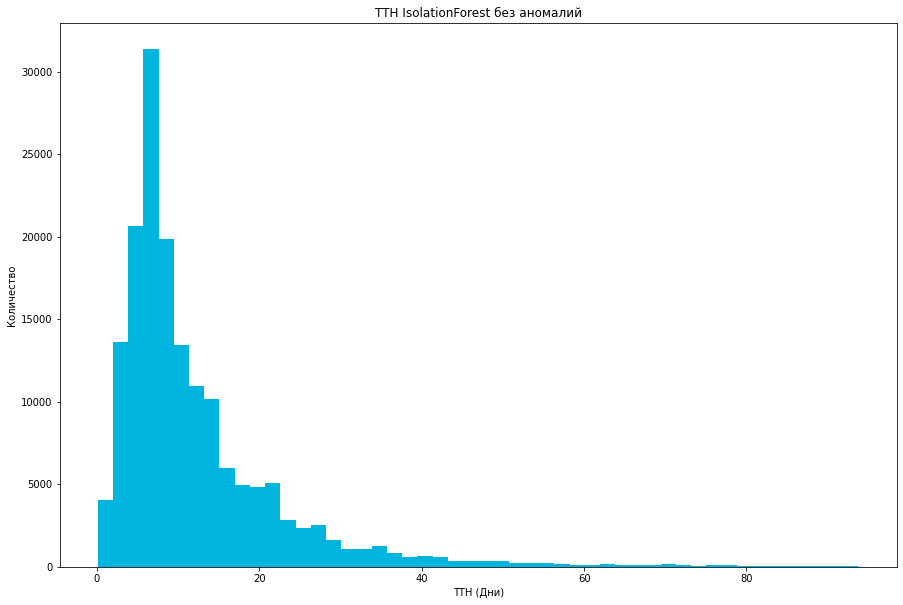

In [27]:
# TTH IsolationForest без аномалий
fig, ax = plt.subplots(1, 1,figsize=(15,10))
bins = 50
ax.hist(df_tth['TTH'][(df_tth['anomaly']==1)&(df_tth['TTH']>0.1)],bins=bins, color = "#00b5dd")
SetTTHLabels('TTH IsolationForest без аномалий')
plt.show()

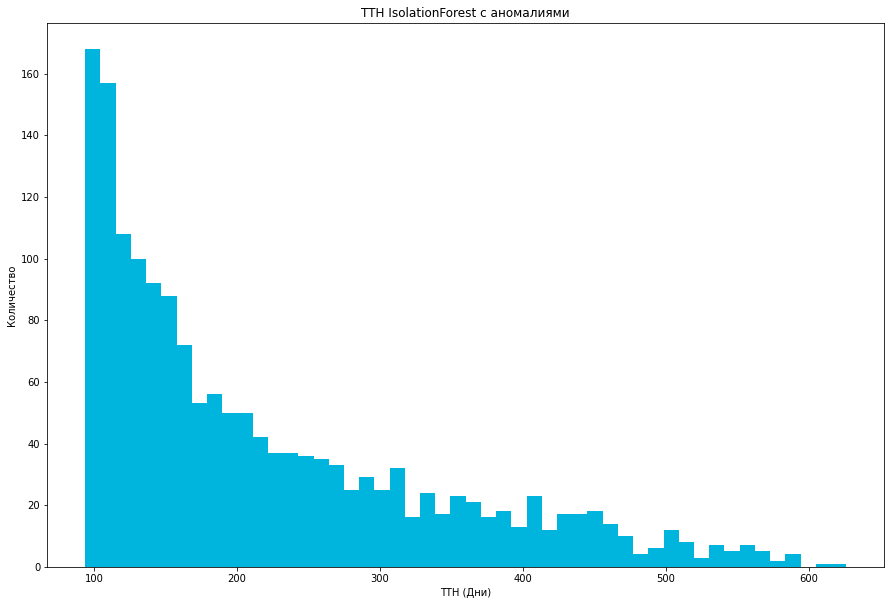

In [28]:
# TTH IsolationForest с аномалиями
fig, ax = plt.subplots(1, 1,figsize=(15,10))
bins = 50
ax.hist(df_tth['TTH'][(df_tth['anomaly']==-1)&(df_tth['TTH']<1000)],bins=bins, color = "#00b5dd")
SetTTHLabels('TTH IsolationForest с аномалиями')
plt.show()

In [29]:
# Запускать один раз!
treshold_down = 0.02
treshold_up = df_tth['TTH'].quantile(0.99)
print("Верхняя граница = "+ str(treshold_up))
df_norm = df_fits.loc[df_fits['id_applicant'].isin(df_tth.loc[df_tth['anomaly']==1, 'id_applicant'])]
df_norm = df_norm.loc[df_norm['id_applicant'].isin(df_tth.loc[df_tth['TTH'] >0.1, 'id_applicant'])]
df_tth = pd.DataFrame(df_tth).drop(columns = 'anomaly')
print(len(df_norm))


df_tth_norm = df_tth.loc[df_tth['id_applicant'].isin(df_norm['id_applicant'])]

Верхняя граница = 93.02681978548368
2043408


In [30]:
print("Количество норм аппликантов = "+ str(len(df_norm.id_applicant.unique())))

Количество норм аппликантов = 164271


In [31]:
df_norm

,index,id_applicant,id_partner,id_log,department_id,action_date,stage_name,activity_name,result_name,position_name,is_active_action,is_open_action,action_time,is_fits,after_fit,place,TTH
3660,23065,4879878,3411802,-1,25070,2020-04-13 09:54:11.130665+00:00,Создание кандидата,NaN,NaN,Продавец-кассир,1,0,0.000000,0,NaN,0,0.327678
3661,23066,4879878,3411802,27071332,25070,2020-04-13 09:54:32.426053+00:00,Обработка,Провести первичную обработку,Подходит,Продавец-кассир,1,0,0.000013,0,NaN,1,0.327678
3662,23067,4879878,3411802,27071333,25070,2020-04-13 09:54:33.513812+00:00,Обработка,Проверка формы обращения,Не резерв,Продавец-кассир,1,0,0.000014,0,NaN,2,0.327678
3663,23068,4879878,3411802,27071334,25070,2020-04-13 09:54:34.747243+00:00,Интервью с руководителем,Назначить интервью с руководителем,Встреча назначена,Продавец-кассир,1,0,0.000012,0,NaN,3,0.327678
3664,23069,4879878,3411802,27071335,25070,2020-04-13 09:54:35.803771+00:00,Интервью с руководителем,Узнать результаты интервью с руководителем,Подходит,Продавец-кассир,1,0,0.000011,0,NaN,4,0.327678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2318758,10704425,2196746,2393754,10894251,6715,2018-01-09 09:27:48.426849+00:00,Назначение времени на оформление/медосмотр,Назначить время на оформление/медосмотр,Время назначено,Продавец-кассир,1,0,7.332564,0,NaN,6,27.685659
2318759,10704426,2196746,2393754,11063771,6715,2018-01-16 17:26:41.952795+00:00,Оформление,Узнать результаты приема,В ожидании,Продавец-кассир,1,0,2.021458,0,NaN,7,27.685659
2318760,10704427,2196746,2393754,11114834,6715,2018-01-18 17:57:35.949129+00:00,Оформление,Узнать результаты приема,В ожидании,Продавец-кассир,1,0,7.920533,0,NaN,8,27.685659
2318761,10704428,2196746,2393754,11256014,6715,2018-01-26 16:03:09.962365+00:00,Оформление,Узнать результаты приема,В ожидании,Продавец-кассир,1,0,6.292864,0,NaN,9,27.685659


In [32]:
# Отсортированные средние по результатам
df_norm.groupby(['result_name'])['place'].mean().sort_values()

result_name
Источник не Яндекс Цифра                    2.108960
Источник Яндекс Цифра                       2.120000
Кадровый резерв                             2.476684
Встреча назначена                           4.041557
Перенос руководителя                        4.515152
Подходит                                    4.885506
Перенос кандидата                           4.897891
Нет обратной связи                          5.235389
Не подготовлена                             5.400000
Не подходит                                 5.823529
Согласование повторного приема              5.875491
Уточнение данных                            6.120968
Подготовлена                                6.147729
Резерв                                      6.185000
Перенос звонка                              6.266004
Не получено                                 6.375000
Не резерв                                   6.543662
Интервью с руководителем                    6.761798
Получено                          

In [33]:
# Отсортированное среднее по стадиям
df_norm.groupby(['stage_name'])['place'].mean().sort_values()

stage_name
Создание кандидата                             0.063815
Обработка                                      2.119257
Интервью с руководителем                       4.615842
Не прошел СБ                                   6.895899
СБ                                             7.150648
Резерв                                         7.155080
Кадровый резерв                                8.000000
Назначение времени на оформление/медосмотр     8.301236
Смена вакансии                                 9.397790
Мы отказали                                    9.863636
Ожидание                                      10.091268
Оформление                                    10.380049
Отказался                                     11.370479
Выход на работу                               11.402390
Name: place, dtype: float64

In [34]:
# Отсортированное среднее по активностям
df_norm.groupby(['activity_name'])['place'].mean().sort_values()

activity_name
Провести первичную обработку                                 1.030529
Проверка источника                                           2.117320
Назначить интервью с руководителем                           4.044397
Узнать результаты интервью с руководителем                   5.137452
Подготовить анкету кандидата                                 6.144098
Проверка формы обращения                                     6.539384
Получить согласование повторного приема и отправить в СБ     6.911055
Вывести из черного списка                                    7.000000
Узнать результаты СБ                                         7.166016
Назначить время на оформление                                7.411099
Назначить время на оформление/медосмотр                      8.735783
Предоставить обратную связь по кандидату                     8.741039
Назначить время на оформление/медосмотр (недозвон)           8.967553
Узнать результаты медосмотра                                 9.760915
Вернут

In [35]:
# Функции для построения каких-то графиков
def vizScatTTH(df, xColumns, yColumn,  x_c, y_c):
    fig, axs = plt.subplots( y_c, x_c, figsize=(15,15))
    df = df[df[yColumn] <82]
    i = 0
    for column in xColumns:
        x = int(i / x_c)
        y = i % x_c    
        axs[x,y].set_ylabel("TTH")
        axs[x,y].set_xlabel(column)
        axs[x,y].scatter(df[column],df[yColumn],s=3, label="original")
        i += 1
    plt.show()

def columnDiscraber(df, column_name, x_col, y_col):
    activites =  df.groupby([column_name])['place'].mean().sort_values().reset_index()[column_name].values

    df_activity_mean = df.groupby([column_name, 'id_applicant'])['action_time'].mean().sort_values().reset_index()
    df_activity_mean = df_activity_mean.loc[df_activity_mean[column_name].isin(activites)]

    temp_df = pd.get_dummies(df_activity_mean[column_name]).rename(columns=lambda x: str(x))
    df_activity_mean =  pd.concat((df_activity_mean, temp_df), axis=1)

    for activity in activites:
        df_activity_mean.loc[df_activity_mean[activity]==1, activity] = df_activity_mean['action_time'] 
    df_activity_mean.fillna(0)
    df_activity_mean = df_activity_mean.groupby(['id_applicant']).sum().reset_index()
    df_activity_mean = df_activity_mean.rename(columns={"action_time": 'TTH'})
    vizScatTTH(df_activity_mean, activites,'TTH', x_col, y_col)

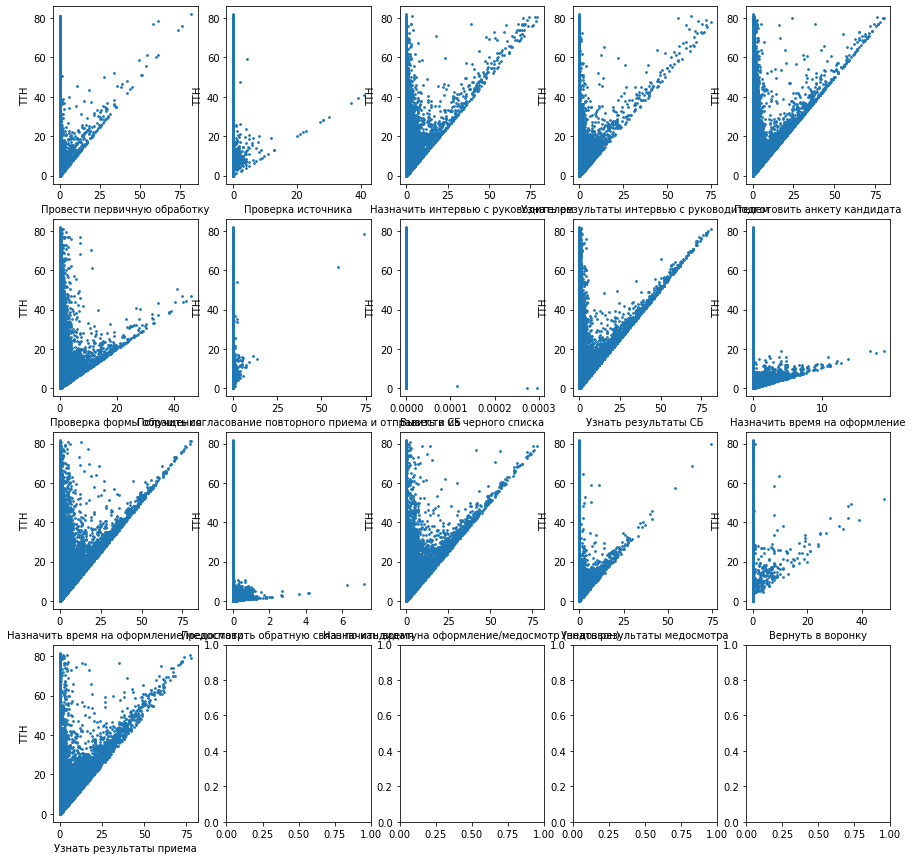

In [36]:
# График ? по активностям
columnDiscraber(df_norm, 'activity_name', 5, 4)

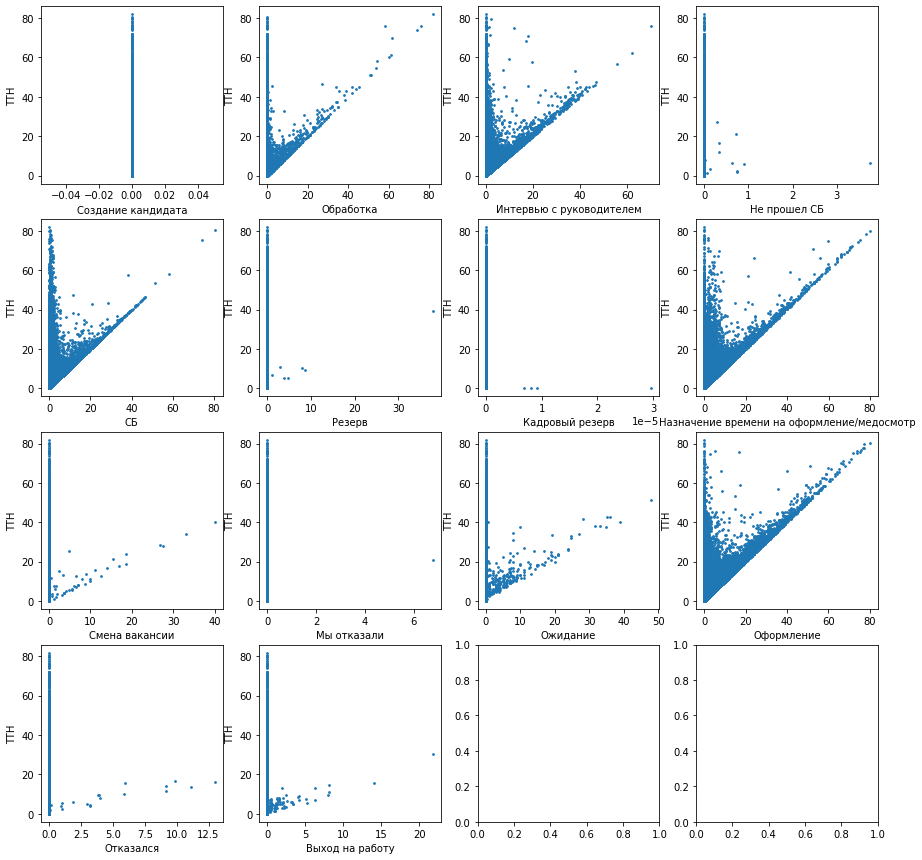

In [37]:
# График ? по стадиям
columnDiscraber(df_norm, 'stage_name', 4, 4)

In [38]:
# Какие-то функции
def dfAllDays(df):
    date_min = df['action_date'].min().tzinfo.localize(pd.to_datetime(20180101, format='%Y%m%d'))
    day_max = int(toDays(df['action_date'].max() - date_min)) + 1 # In days
    range_days = range(0, day_max)
    return pd.DataFrame(range_days, range_days, columns =['days']) 
    
    
    
def stageInDays(stage_action_name, df, show_scatter = True, up_date_treshold = 730, applicants = False):
    stage_date = df[df['stage_name'] == stage_action_name].groupby(['id_applicant']). agg({'action_date': 'max','action_time':'sum'}).reset_index()
    stage_date = stage_date.rename(columns={"action_date": 'max_date'})
    stage_date = pd.merge(stage_date,df[df['stage_name'] == stage_action_name].groupby(['id_applicant'])['action_date'].min().reset_index(), how = 'left', on="id_applicant")
    stage_date = stage_date.rename(columns={"action_date": 'min_date'})

    date = stage_date['min_date'].min().tzinfo.localize(pd.to_datetime(20180101, format='%Y%m%d'))
    
    stage_date['stage_time_min'] = (toDays(stage_date['min_date'] - date)).astype(int) # In days
    stage_date['stage_time_max'] = (toDays(stage_date['max_date'] - date)).astype(int) # In days


    applicant_days = dfAllDays(df)
    applicant_days['applicants'] = 0
    for cur_date in applicant_days['days']:
        applicant_days.loc[cur_date,'applicants'] = len(stage_date[(stage_date['stage_time_max']>= cur_date)&(stage_date['stage_time_min']<= cur_date)])
    applicant_days = applicant_days[applicant_days['days'] < up_date_treshold]
    
    stage_date = pd.merge(stage_date, applicant_days.rename(columns={"days": 'stage_time_min'}), how = 'left', on="stage_time_min")
    if show_scatter:
        plt.subplots(figsize=(15,10))
        plt.scatter(applicant_days['days'], applicant_days['applicants'], linewidth=1, label="original",s=5)
        plt.title("Стадия "+ stage_action_name)
        plt.xlabel('Дни с начала 2018 года')
        plt.ylabel('Количество аппликантов на стадии')
        plt.grid(True)
        plt.show()
    if applicants:
        return applicant_days, stage_date
    else:
        return stage_date

In [39]:
# Стадии среднее * количество
stages_g =  df_norm.dropna(subset=['action_time']).groupby(['stage_name'])['action_time'].describe() # ['stage_name', 'activity_name']
stages_g['sum'] = stages_g['mean'] * stages_g['count']
stages_g

,count,mean,std,min,25%,50%,75%,max,sum
stage_name,,,,,,,,,
Выход на работу,152.0,1.106562,2.560745,0.000000,0.000000,0.005966,1.224158,21.760230,168.197428
Интервью с руководителем,411458.0,0.332766,2.251634,0.000000,0.000008,0.000011,0.000016,92.340400,136919.077587
Кадровый резерв,4.0,0.000013,0.000011,0.000007,0.000008,0.000009,0.000014,0.000030,0.000054
Мы отказали,20.0,0.339614,1.518742,0.000006,0.000008,0.000011,0.000016,6.792035,6.792274
Назначение времени на оформление/медосмотр,194020.0,2.569659,5.462191,0.000000,0.000154,0.883039,3.072229,91.134215,498565.263239
Не прошел СБ,317.0,0.027362,0.231580,0.000000,0.000009,0.000011,0.000014,3.742623,8.673824
Обработка,299950.0,0.051633,1.202444,0.000000,0.000009,0.000011,0.000014,88.688422,15487.439811
Ожидание,8565.0,0.223616,1.861297,0.000000,0.000062,0.000159,0.000349,47.986730,1915.272326
Отказался,1022.0,0.088450,0.829058,0.000000,0.000011,0.000012,0.000014,12.966977,90.395566


In [40]:
# Стадии. Их нормированное количество
date = df_norm['action_date'].min().tzinfo.localize(pd.to_datetime(20200101, format='%Y%m%d'))
df_norm[df_norm['action_date']>date].groupby('stage_name')['action_time'].sum()

stage_name
Выход на работу                                   0.004620
Интервью с руководителем                       1100.699484
Назначение времени на оформление/медосмотр        0.000000
Обработка                                        13.011987
Отказался                                         0.000117
Оформление                                    19824.040202
СБ                                             4379.018500
Создание кандидата                                0.000000
Name: action_time, dtype: float64

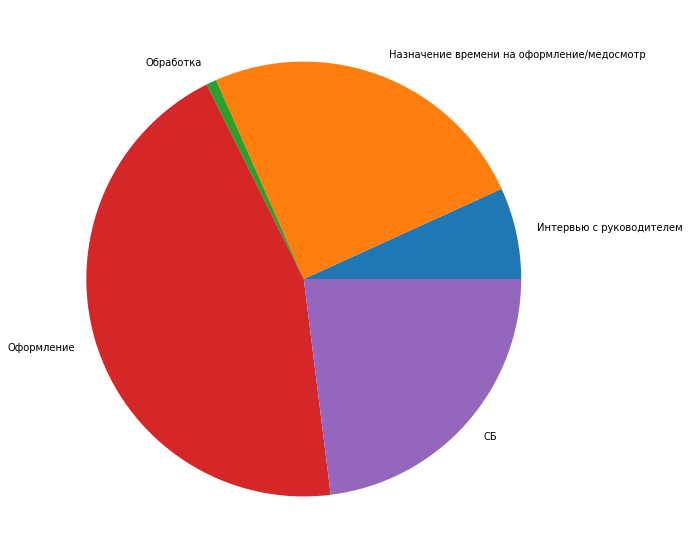

In [41]:
# Круговая диаграмма по стадиям
stage_pie_mask = stages_g['sum'] > 2200
stage_sum =stages_g[stage_pie_mask]['sum'].sum()
stage_sum

y = stages_g[stage_pie_mask]['sum'] / stage_sum
mylabels = stages_g[stage_pie_mask].index

plt.subplots(1, 1,figsize=(15,10))
plt.pie(y, labels = mylabels)
plt.show() 

In [42]:
# ХЗ
reserved_applicants = df.loc[df['result_name']=="Кадровый резерв", 'id_applicant'].unique()
reserved_applicants= np.append(reserved_applicants, df.loc[df['stage_name']=="Кадровый резерв", 'id_applicant'].unique())
reserved_applicants = np.append(reserved_applicants, df.loc[df['stage_name']=="Резерв", 'id_applicant'].unique())
reserved_applicants = np.unique(reserved_applicants)

In [43]:
# ХЗ
sb_c = 1
int_c = 1
df_sb_int = df_fits[(df_fits['id_applicant'].isin(reserved_applicants))& ((df_fits['stage_name']=='СБ') | (df_fits['stage_name']=='Интервью с руководителем'))]
df_sb_int = df_sb_int.groupby(['id_applicant', 'stage_name'])['action_time'].sum().reset_index()
df_sb_int = pd.merge(df_sb_int[df_sb_int['stage_name'] == 'Интервью с руководителем'], df_sb_int[df_sb_int['stage_name'] == 'СБ'], how = 'outer', on="id_applicant")
df_sb_int['action_time_x(short)'] = df_sb_int['action_time_x']
df_sb_int.loc[(df_sb_int['action_time_x(short)']>sb_c), 'action_time_x(short)'] = sb_c
df_sb_int['action_time_y(short)'] = df_sb_int['action_time_y']
df_sb_int.loc[df_sb_int['action_time_y(short)']>int_c, 'action_time_y(short)'] = int_c
df_sb_int.rename(columns = {'action_time_x':'interview_time', 'action_time_x(short)':'interview_time(short)','action_time_y':'sb_time', 'action_time_y(short)':'sb_time(short)'}, inplace = True)
df_sb_int = df_sb_int.drop(['stage_name_x','stage_name_y'] , axis=1)
# df_sb_int.to_excel('reserved.xlsx')

In [44]:
# ХЗ
sum_time_med_c = 3
sum_time_medN_c = 3
sum_time_res_c = 3
df_med = df_fits[(df_fits['activity_name'] == 'Назначить время на оформление/медосмотр')].groupby(['activity_name', 'id_applicant']).agg({'action_time': ['sum','count']}).reset_index()
df_med.columns = df_med.columns.droplevel(1)
df_med = df_med.drop('activity_name', axis=1)
df_med.columns.values[1] = "sum_time_med"
df_med.columns.values[2] = "count_time_med"
print(len(df_med))
df_med2 = df_fits[(df_fits['activity_name'] == 'Назначить время на оформление/медосмотр (недозвон)')].groupby(['activity_name', 'id_applicant']).agg({'action_time': ['sum','count']}).reset_index()
df_med2.columns = df_med2.columns.droplevel(1)
df_med2 = df_med2.drop('activity_name', axis=1)
df_med2.columns.values[1] = "sum_time_medN"
df_med2.columns.values[2] = "count_time_medN"
print(len(df_med2))
df_med =  pd.merge(df_med, df_med2, how = 'outer', on="id_applicant")
df_med2 = df_fits.dropna(subset=['action_time'])[(df_fits['activity_name'] == 'Узнать результаты приема')].groupby(['activity_name', 'id_applicant']).agg({'action_time': ['sum','count']}).reset_index()
df_med2.columns = df_med2.columns.droplevel(1)
df_med2 = df_med2.drop('activity_name', axis=1)
df_med2.columns.values[1] = "sum_time_res"
df_med2.columns.values[2] = "count_time_res"
print(len(df_med2))
df_med =  pd.merge(df_med, df_med2, how = 'outer', on="id_applicant")
df_med['sum_time_med(short)'] = df_med['sum_time_med']
df_med.loc[(df_med['sum_time_med(short)']>sum_time_med_c), 'sum_time_med(short)'] = sum_time_med_c
df_med['sum_time_medN(short)'] = df_med['sum_time_medN']
df_med.loc[df_med['sum_time_medN(short)']>sum_time_medN_c, 'sum_time_medN(short)'] = sum_time_medN_c
df_med['sum_time_res(short)'] = df_med['sum_time_res']
df_med.loc[df_med['sum_time_res(short)']>sum_time_res_c, 'sum_time_res(short)'] = sum_time_res_c
# df_med.to_excel('med_time.xlsx')

185069
80014


Boolean Series key will be reindexed to match DataFrame index.


80988


In [45]:
# Статистика по результатам
results_g =  df_fits.dropna(subset=['action_time']).groupby(['result_name'])['action_time'].describe()
results_g

,count,mean,std,min,25%,50%,75%,max
result_name,,,,,,,,
В белый список,4.0,0.000259,0.000101,0.000114,0.000234,0.000286,0.000310,0.000349
В ожидании,153482.0,3.158289,5.908128,0.000000,1.016673,1.918097,3.894268,520.710384
Время назначено,191517.0,1.840695,4.353546,0.000000,0.000073,0.000276,2.811733,291.880512
Встреча назначена,224659.0,0.594591,8.826268,0.000000,0.000009,0.000011,0.000015,600.796568
Интервью с руководителем,482.0,0.507145,5.623006,0.000016,0.000107,0.000176,0.000488,113.246137
Источник Яндекс Цифра,27.0,0.496732,1.423606,0.000011,0.000198,0.034347,0.086146,7.030999
Источник не Яндекс Цифра,45338.0,0.144579,5.950515,0.000000,0.000011,0.000013,0.000017,469.080663
Кадровый резерв,197.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Назначить время на оформление/медосмотр,3179.0,0.302307,2.244807,0.000000,0.000129,0.000187,0.000383,38.193814


In [46]:
# Статистика по активностям
activities_g =  df_fits.dropna(subset=['action_time']).groupby(['activity_name'])['action_time'].describe()
activities_g

,count,mean,std,min,25%,50%,75%,max
activity_name,,,,,,,,
Вернуть в воронку,8777.0,0.242731,2.267561e+00,0.000000,0.000062,0.000159,0.000346,113.246137
Вывести из черного списка,5.0,0.000208,1.429926e-04,0.000006,0.000114,0.000274,0.000297,0.000349
Назначить время для гайд-интервью,2.0,0.000012,7.476836e-07,0.000012,0.000012,0.000012,0.000012,0.000013
Назначить время на оформление,8211.0,1.034397,1.984597e+00,0.000000,0.000065,0.000233,1.043698,18.966384
Назначить время на оформление/медосмотр,218463.0,2.228467,5.390705e+00,0.000000,0.000131,0.221104,2.827222,430.056809
Назначить время на оформление/медосмотр (недозвон),124348.0,2.915728,7.302221e+00,0.000000,0.000071,0.809676,3.174616,392.058357
Назначить групповое собеседование и тестирование,2.0,0.000008,1.037589e-06,0.000007,0.000008,0.000008,0.000008,0.000009
Назначить интервью с руководителем,225710.0,0.617507,8.965768e+00,0.000000,0.000009,0.000011,0.000015,600.796568
Подготовить анкету кандидата,220390.0,1.376653,1.224314e+01,0.000000,0.000013,0.175961,0.832853,527.944208


In [47]:
# Статистика ТТН по департаментам
df_new_tth = df_tth.reset_index(drop = True)
# df_med
df_new_tth = pd.merge(df_new_tth, df_med, how = 'left', on="id_applicant")
df_new_tth.fillna(0, inplace = True)
df_new_tth['TTH'] = df_new_tth['TTH'] - (df_new_tth['sum_time_med'] - df_new_tth['sum_time_med(short)'] + df_new_tth['sum_time_medN'] - df_new_tth['sum_time_medN(short)'] + df_new_tth['sum_time_res'] - df_new_tth['sum_time_res(short)'])
df_new_tth = df_new_tth[['id_applicant','TTH']] 

# df_sb_int
df_new_tth = pd.merge(df_new_tth, df_sb_int, how = 'left', on="id_applicant")
df_new_tth.fillna(0, inplace = True)
df_new_tth['TTH'] = df_new_tth['TTH'] - (df_new_tth['sb_time'] - df_new_tth['sb_time(short)'] + df_new_tth['interview_time'] - df_new_tth['interview_time(short)'])
df_new_tth = df_new_tth[['id_applicant','TTH']] 


# df_new_tth.to_excel('TTH_NEW.xlsx')
df_tth_new_dep =  df_fits.dropna(subset=['action_time']).groupby(['id_applicant', 'department_id'])['action_time'].count().reset_index()
df_tth_new_dep = df_tth_new_dep.join(df_new_tth.set_index('id_applicant'), on='id_applicant')
df_tth_new_dep = df_tth_new_dep.groupby(['department_id'])['TTH'].median().reset_index()
df_tth_new_dep.to_excel('TTH_DEP_NEW.xlsx')
df_tth_new_dep.describe()


,department_id,TTH
count,15550.000000,15323.000000
mean,22926.999293,6.370110
std,13317.867234,5.948887
min,5637.000000,0.113419
25%,9945.250000,5.099309
50%,24309.000000,6.011680
75%,32716.750000,6.916226
max,49859.000000,431.057327


In [48]:
# Медианный квантиль по ТТН по департаментам
quantile_dep = df_tth_dep['TTH_median'].quantile(.999)
quantile_dep

19.0

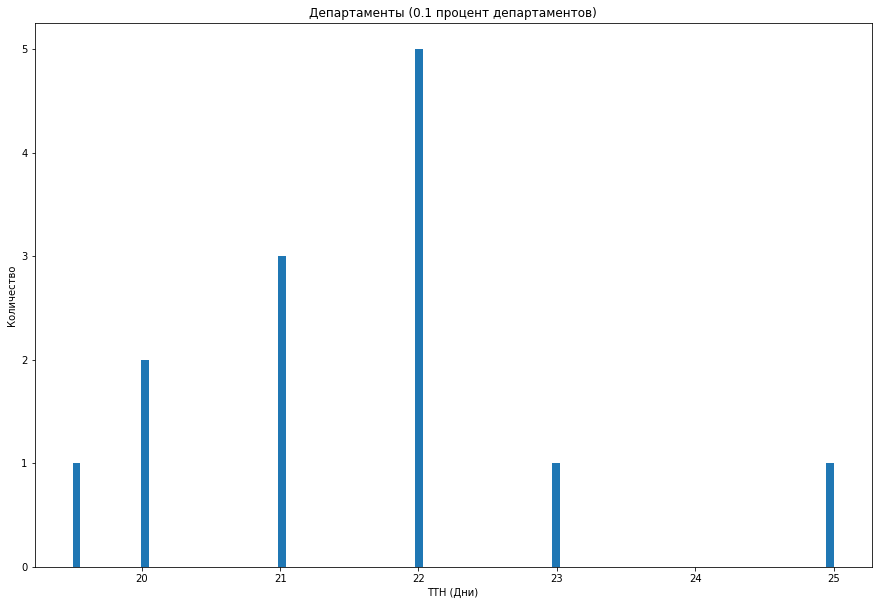

In [49]:
# График ТТН по департаментам (0,1 процент департаментов)
fig, ax = plt.subplots(1, 1,figsize=(15,10))
bins = 100
ax.hist(df_tth_dep['TTH_median'][(df_tth_dep['TTH_median']>quantile_dep)],bins=bins)
SetTTHLabels('Департаменты (0.1 процент департаментов)')
plt.show()

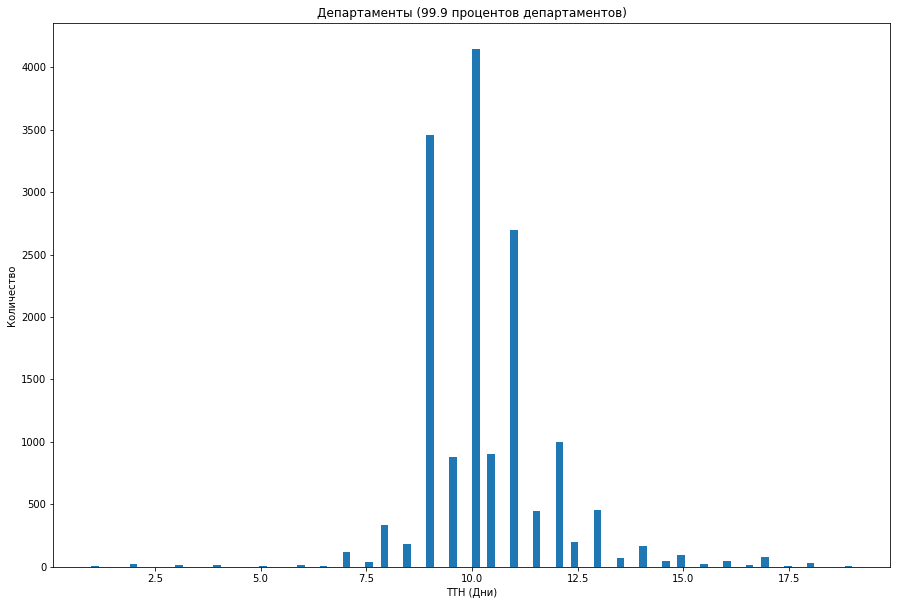

In [50]:
# График ТТН по департаментам (99,9 процентов департаментов)
fig, ax = plt.subplots(1, 1,figsize=(15,10))
bins = 100
ax.hist(df_tth_dep['TTH_median'][(df_tth_dep['TTH_median']<=quantile_dep)],bins=bins)
SetTTHLabels('Департаменты (99.9 процентов департаментов)')
plt.show()

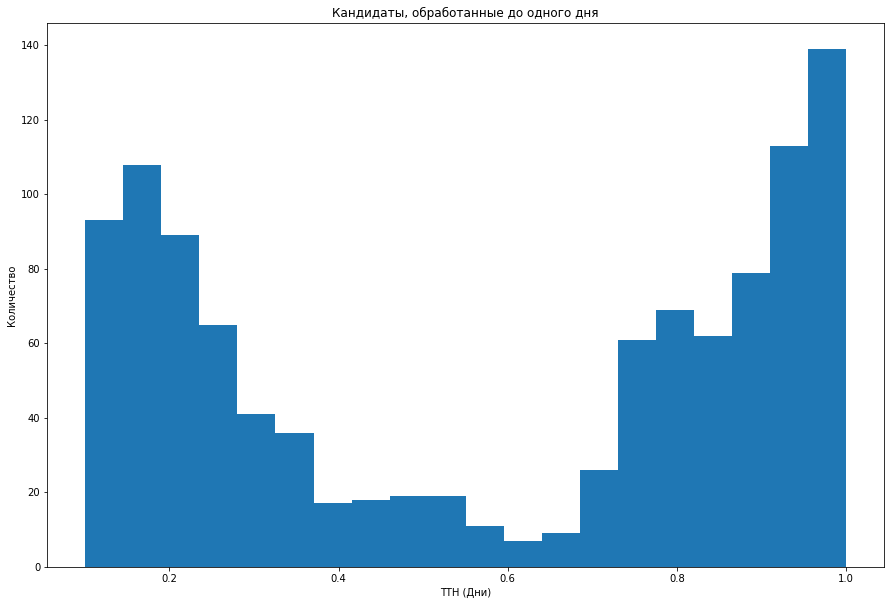

In [51]:
# График кандидатов, обработанных до одного дня
fig, ax = plt.subplots(1, 1,figsize=(15,10))
bins = 20
ax.hist(df_tth['TTH'][(df_tth['TTH']<=1)],bins=bins)
SetTTHLabels('Кандидаты, обработанные до одного дня')
plt.show()

In [52]:
# Квантиль
quantile_tth = df_tth['TTH'].quantile(.99)
quantile_tth

93.02681978548368

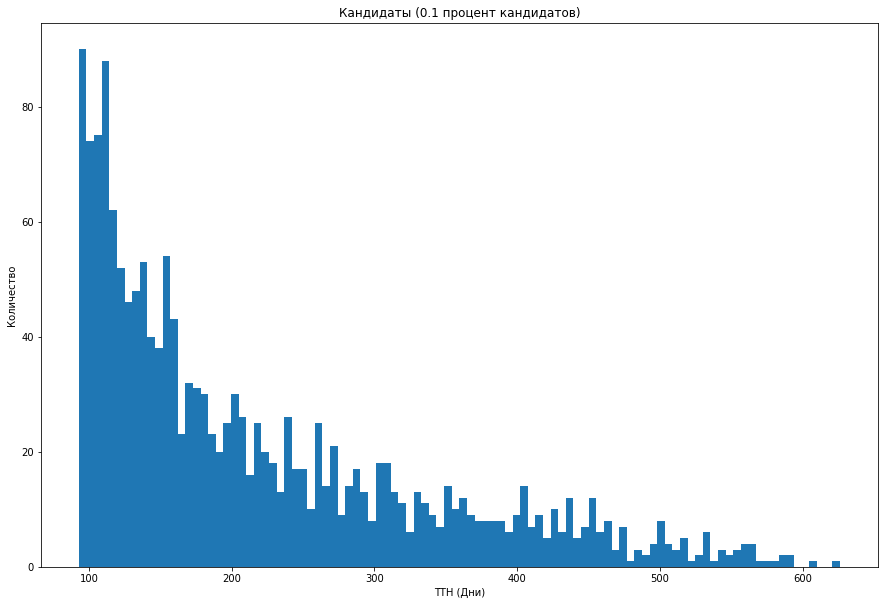

In [53]:
# График Кандидаты (0,1 процент кандидатов)
fig, ax = plt.subplots(1, 1,figsize=(15,10))
ax.hist(df_tth['TTH'][(df_tth['TTH']<5000)&(df_tth['TTH']>quantile_tth)],bins=100)
SetTTHLabels('Кандидаты (0.1 процент кандидатов)')
plt.show()

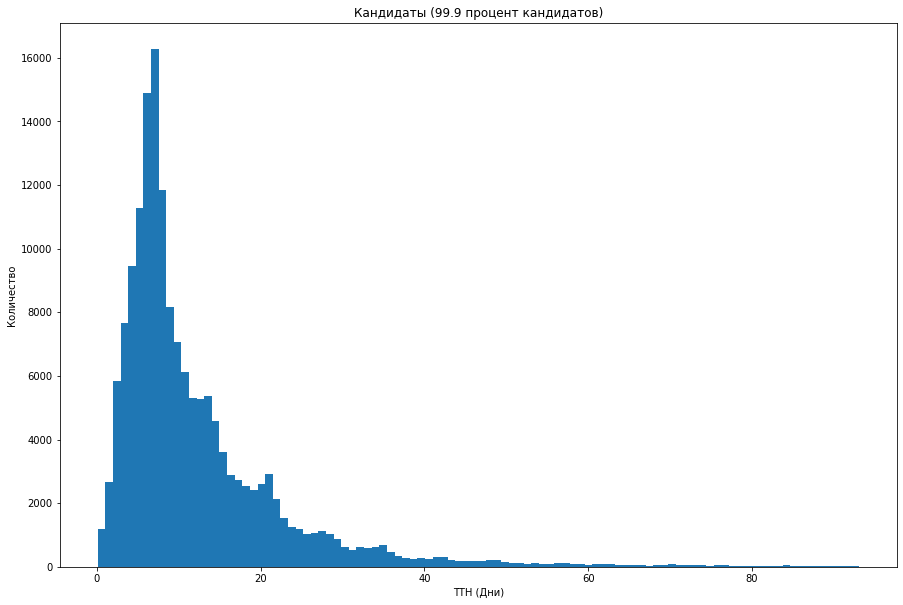

In [54]:
# График Кандидаты (99,9 процентов кандидатов)
fig, ax = plt.subplots(1, 1,figsize=(15,10))
ax.hist(df_tth['TTH'][(df_tth['TTH']<quantile_tth)& (df_tth['TTH']>0)], bins = 100)
SetTTHLabels('Кандидаты (99.9 процент кандидатов)')
plt.show()

In [55]:
# Квантиль 99,9 по action_time
df_fits['action_time'].quantile(.999)

68.2677492796434

In [56]:
# ТТН > 100
df_tth['TTH'][df_tth['TTH']>100]

78        473.820724
129       134.243540
174       533.154021
187       370.023845
312       173.923378
             ...    
149411    100.938892
150358    105.030456
151363    106.354237
151727    106.162903
153141    112.194402
Name: TTH, Length: 1551, dtype: float64

In [57]:
# Построение когорты
df_min_date =df_fits.groupby(['id_applicant'])['action_date'].min().reset_index()
df_cohort = pd.merge(df_tth, df_min_date, how = 'left', on="id_applicant")
df_cohort.rename(columns = {'action_date':'creation_date'}, inplace = True)
fits_min =  df_fits[df_fits['result_name'] == 'Принят'].groupby(['id_applicant'])['action_date'].max().reset_index()
df_cohort = pd.merge(df_cohort, fits_min, how = 'left', on="id_applicant")
df_cohort.rename(columns = {'action_date':'applied_date'}, inplace = True)
date2018 = df_cohort['applied_date'].min().tzinfo.localize(pd.to_datetime(20180101, format='%Y%m%d'))
df_cohort['applied_date_days'] = (df_cohort['applied_date'] - date2018).dt.days % 365
df_cohort['creation_date_days'] = (df_cohort['creation_date'] - date2018).dt.days % 365

In [58]:
df_cohort

,id_applicant,id_partner,department_id,TTH,creation_date,applied_date,applied_date_days,creation_date_days
0,2196746,2393754,6715,27.685659,2018-01-05 06:37:15.434165+00:00,2018-02-01 23:04:53.450437+00:00,31,4
1,2196747,2314693,12252,6.133310,2018-01-05 06:37:54.019063+00:00,2018-01-11 09:51:21.213384+00:00,10,4
2,2196748,2346300,5760,28.251127,2018-01-05 06:39:55.362530+00:00,2018-02-02 12:41:49.992103+00:00,32,4
3,2196752,2393757,32391,17.202996,2018-01-05 06:50:30.704473+00:00,2018-01-22 11:43:14.342473+00:00,21,4
4,2196753,2393758,32156,10.153854,2018-01-05 06:50:31.727665+00:00,2018-01-15 10:32:20.674998+00:00,14,4
...,...,...,...,...,...,...,...,...
165915,4874547,3857100,35046,2.984132,2020-04-10 17:10:11.297074+00:00,2020-04-13 16:47:34.290655+00:00,103,100
165916,4874561,3843493,24135,2.981270,2020-04-10 17:12:31.084382+00:00,2020-04-13 16:45:57.073435+00:00,103,100
165917,4874899,3847746,45624,2.944752,2020-04-10 18:37:18.462768+00:00,2020-04-13 17:18:34.828264+00:00,103,100
165918,4875075,3873082,9996,2.186676,2020-04-11 08:31:29.677060+00:00,2020-04-13 13:00:37.290286+00:00,103,101


In [59]:
date2018 = df_cohort['applied_date'].min().tzinfo.localize(pd.to_datetime(20180101, format='%Y%m%d'))
df_cohort['weeks'] = (df_cohort['applied_date'] - date2018).dt.days
df_cohort['weeks'] = (df_cohort['weeks'] % 365 / 7).astype(int)
df_cohort['TTH_int'] = (df_cohort['TTH']/7).astype(int)

In [60]:
# Функции для построения каких-то графиков
def showHist(data, grouped_data, column_name = 'stage_name', col_threshold = 0, is_special = True, xy = 4):
    
    fig, axs = plt.subplots(xy, xy, figsize=(20,15))
    i = 0
    not_special_const = 5
    
    for col in data[column_name].unique():
        series = data['action_time'][data[column_name] == col]
        time_threshold = not_special_const
        if is_special and col in grouped_data.index:
            time_threshold = grouped_data.loc[col]['75%']
        col_len = len(series)
    
        if col_len > col_threshold:
            x, y =divmod(i, xy)
            i+=1
            axs[x,y].set_xlabel(f'{col}, {col_len}')
            series[series.values < time_threshold].hist(ax=axs[x,y],bins=100)
        print('.', end = '')
    plt.show()

def checkShowHist(data, grouped_data, column_name = 'stage_name', col_threshold = 0, is_special = True, xy = 4):
    
    not_special_const = 5
    if is_special and len(data[column_name].unique()) != len(grouped_data):
        print('Not all columns in grouped_data')
    
    i = 0
    for col in data[column_name].unique():
        series = data['action_time'][data[column_name] == col]
        col_len = len(series)
    
        if col_len > col_threshold:
            x, y =divmod(i, xy)
            if x > xy or y > xy:
                print(f'Too many columns in data for diagramm {xy}*{xy}')                
            i+=1

................

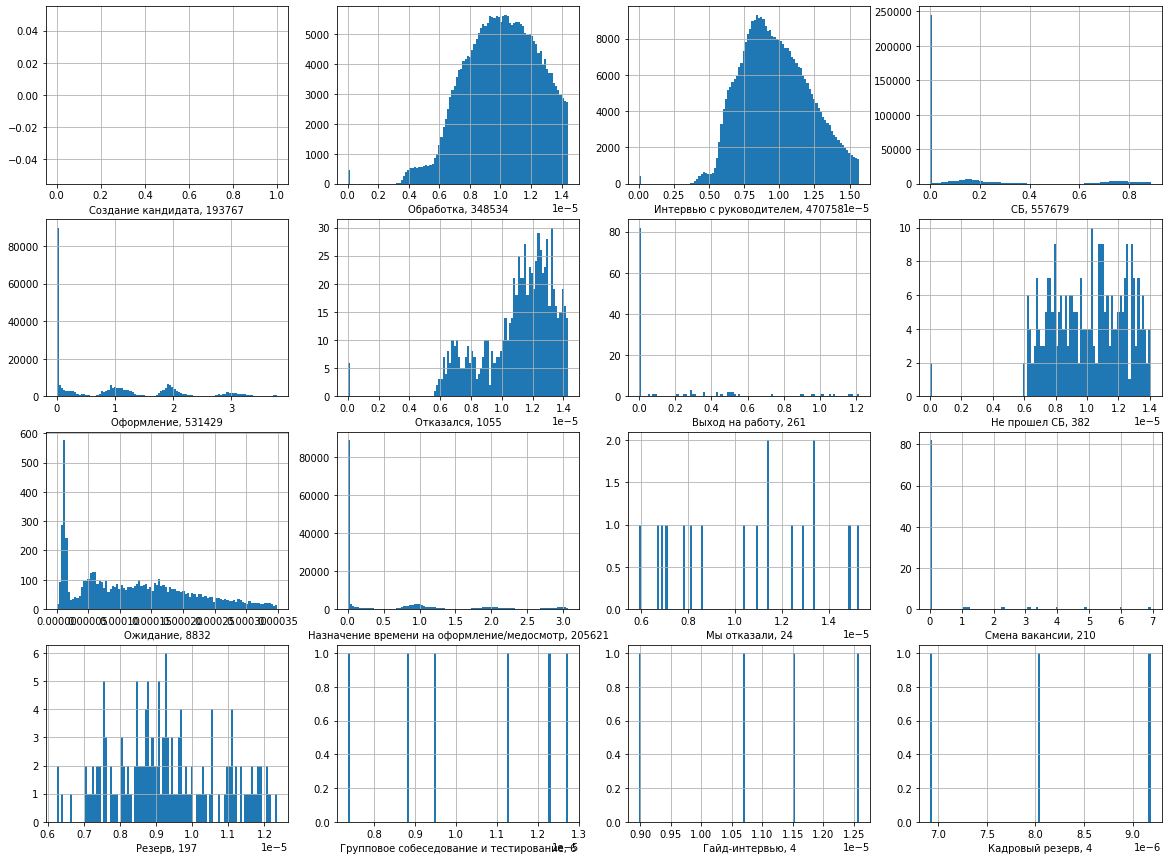

In [61]:
# График по стадиям
showHist(df_fits, stages_g, 'stage_name', stage_threshold)

.................

IndexError: index 4 is out of bounds for axis 0 with size 4

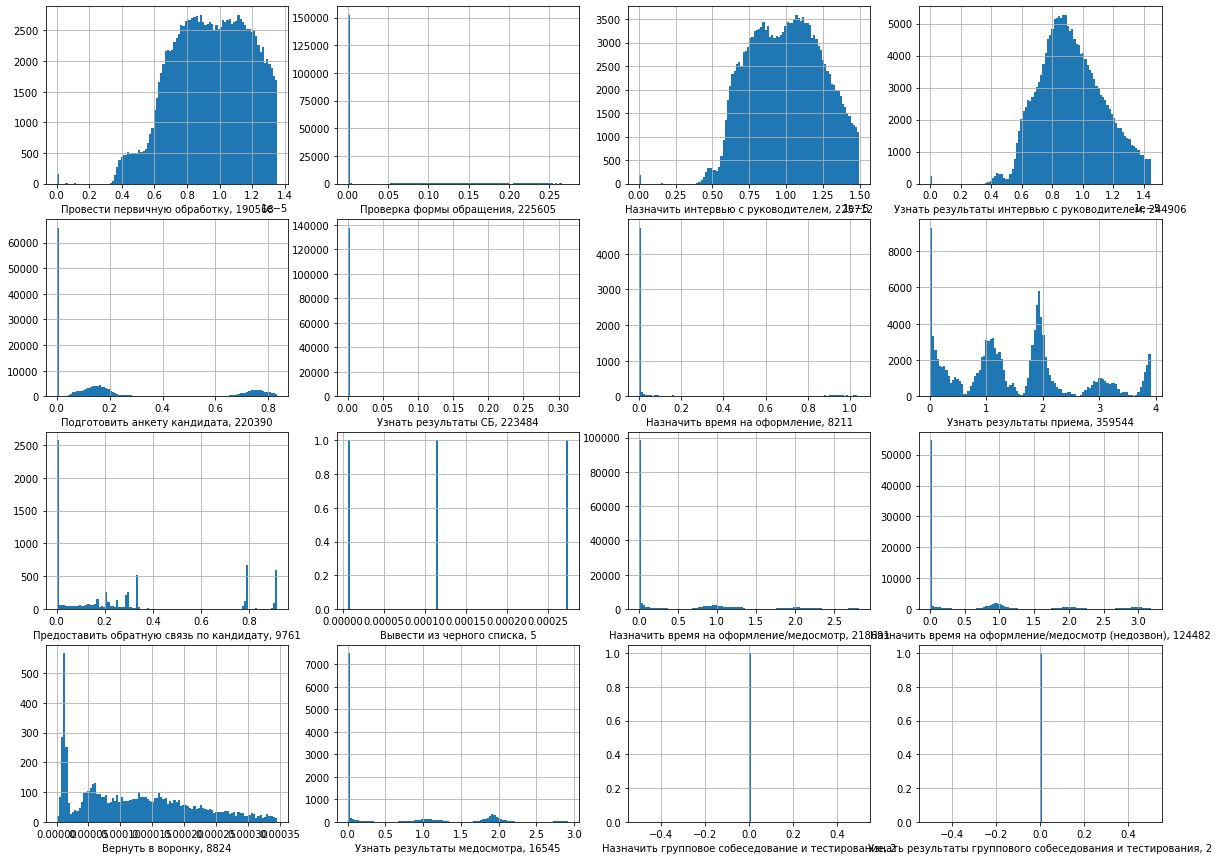

In [62]:
# График по активностям
showHist(df_fits, activities_g, 'activity_name', activity_threshold, True)

.....................................

IndexError: index 6 is out of bounds for axis 0 with size 6

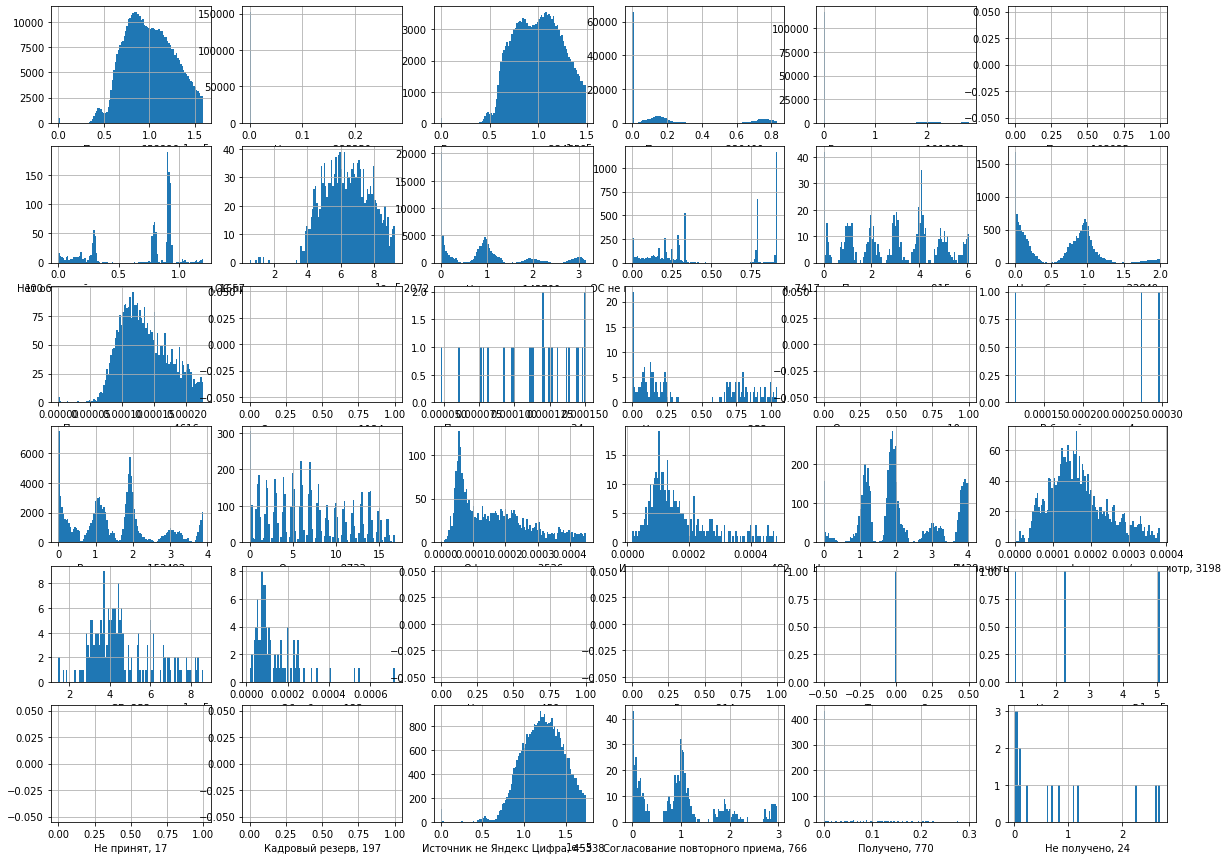

In [63]:
# График по результатам
showHist(df_fits, results_g, 'result_name', result_threshold, True, 6)

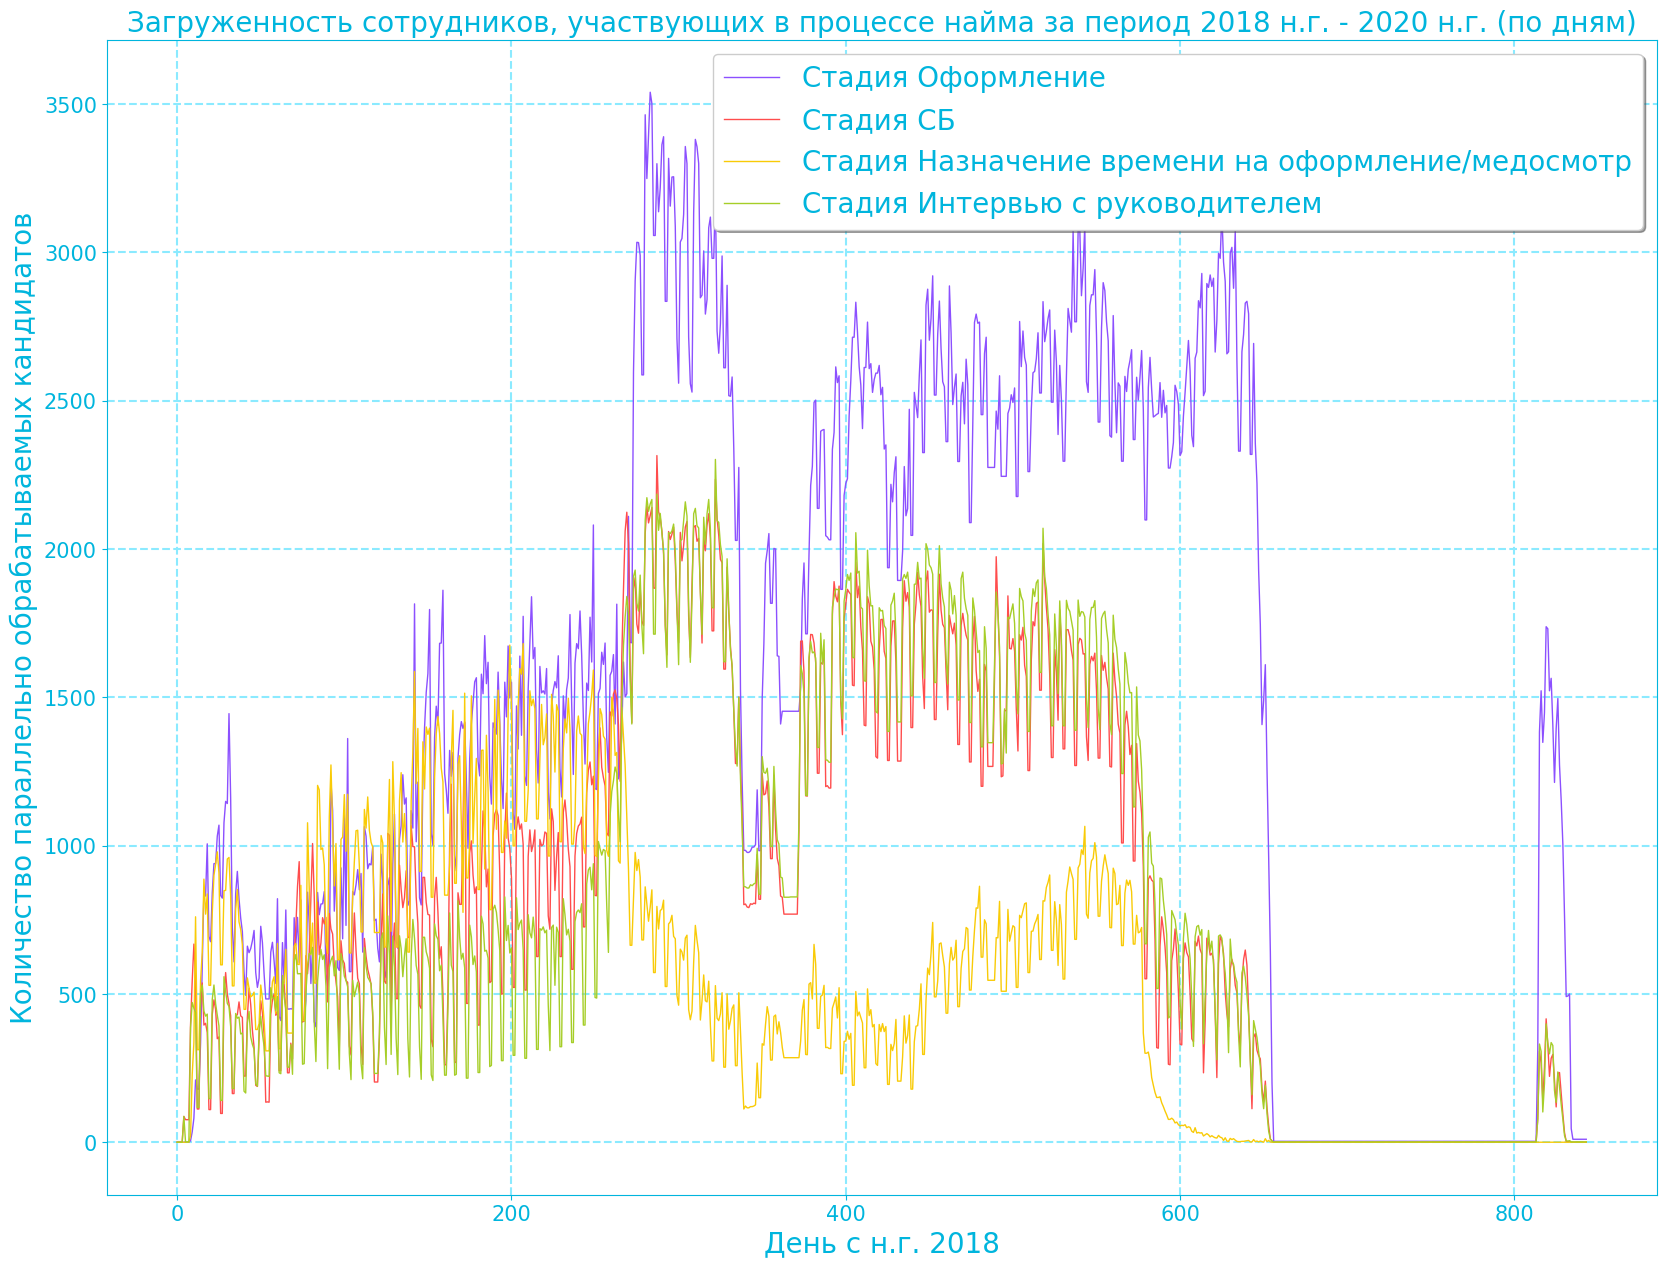

In [66]:
# График Загруженность сотрудников, участвующих в процессе найма за период 2018 н.г. - 2020 н.г. (по дням)
long_stages = ['Оформление', 'СБ', 'Назначение времени на оформление/медосмотр', 'Интервью с руководителем']
colors = ['#00b5dd','#8c50ff', '#ff4d4d', '#f9cb07', '#a6ce28']
grid_color = '#8beaff'

df_long_stages = dfAllDays(df_norm)
df_applicant_stages = pd.DataFrame(df_norm['id_applicant'].unique(), columns = ['id_applicant'])

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 15, 'text.color': colors[0],
                     'axes.labelcolor': colors[0], 'xtick.color': colors[0], 'ytick.color': colors[0],
                     'axes.edgecolor': colors[0], 'ytick.color': colors[0]})

plt.subplots(figsize=(20,15))
i = 1
for stage in long_stages:
    df_long_stage, df_applicant_stage = stageInDays(stage, df_norm, False, 9999, True)
    df_long_stages = pd.merge(df_long_stages, df_long_stage, how = 'left', on="days") 
    new_col_name = stage + ' аппликатнов'
    df_long_stages =  df_long_stages.rename(columns={"applicants": new_col_name})
    plt.plot(df_long_stages['days'], df_long_stages[new_col_name], label="Стадия " + stage, linewidth=1.0, color = colors[i])
    i += 1
    df_applicant_stages = pd.merge(df_applicant_stages, df_applicant_stage[['id_applicant', 'action_time', 'applicants']], how = 'left', on="id_applicant")
    df_applicant_stages =  df_applicant_stages.rename(columns={"applicants": new_col_name, 'action_time':stage+' время'}) 
    
df_applicant_stages = pd.merge(df_applicant_stages, df_tth[['id_applicant', 'TTH']], how = 'left', on="id_applicant") 
plt.title("Загруженность сотрудников, участвующих в процессе найма за период 2018 н.г. - 2020 н.г. (по дням)",
              fontsize = 20, color = colors[0])
plt.xlabel('День с н.г. 2018',
              fontsize = 20, color = colors[0])
plt.ylabel('Количество параллельно обрабатываемых кандидатов',
              fontsize = 20, color = colors[0])
plt.legend(loc='best',fancybox=True, shadow=True,
              fontsize = 20)
plt.grid(True)
plt.grid(linewidth = 1.5, ls ='--', color = grid_color)
 
plt.savefig('days_zagruz.png')


In [67]:
# ХЗ 
date_min = df_norm['action_date'].min().tzinfo.localize(pd.to_datetime(20180101, format='%Y%m%d'))
df_norm['days'] = (toDays(df_norm['action_date'] - date_min)).astype(int)  
df_norm = pd.merge(df_norm, df_long_stages, how = 'left', on="days")
df_applicant_stages = pd.merge(df_applicant_stages, df_norm[['id_applicant', 'days']], how = 'left', on="id_applicant")

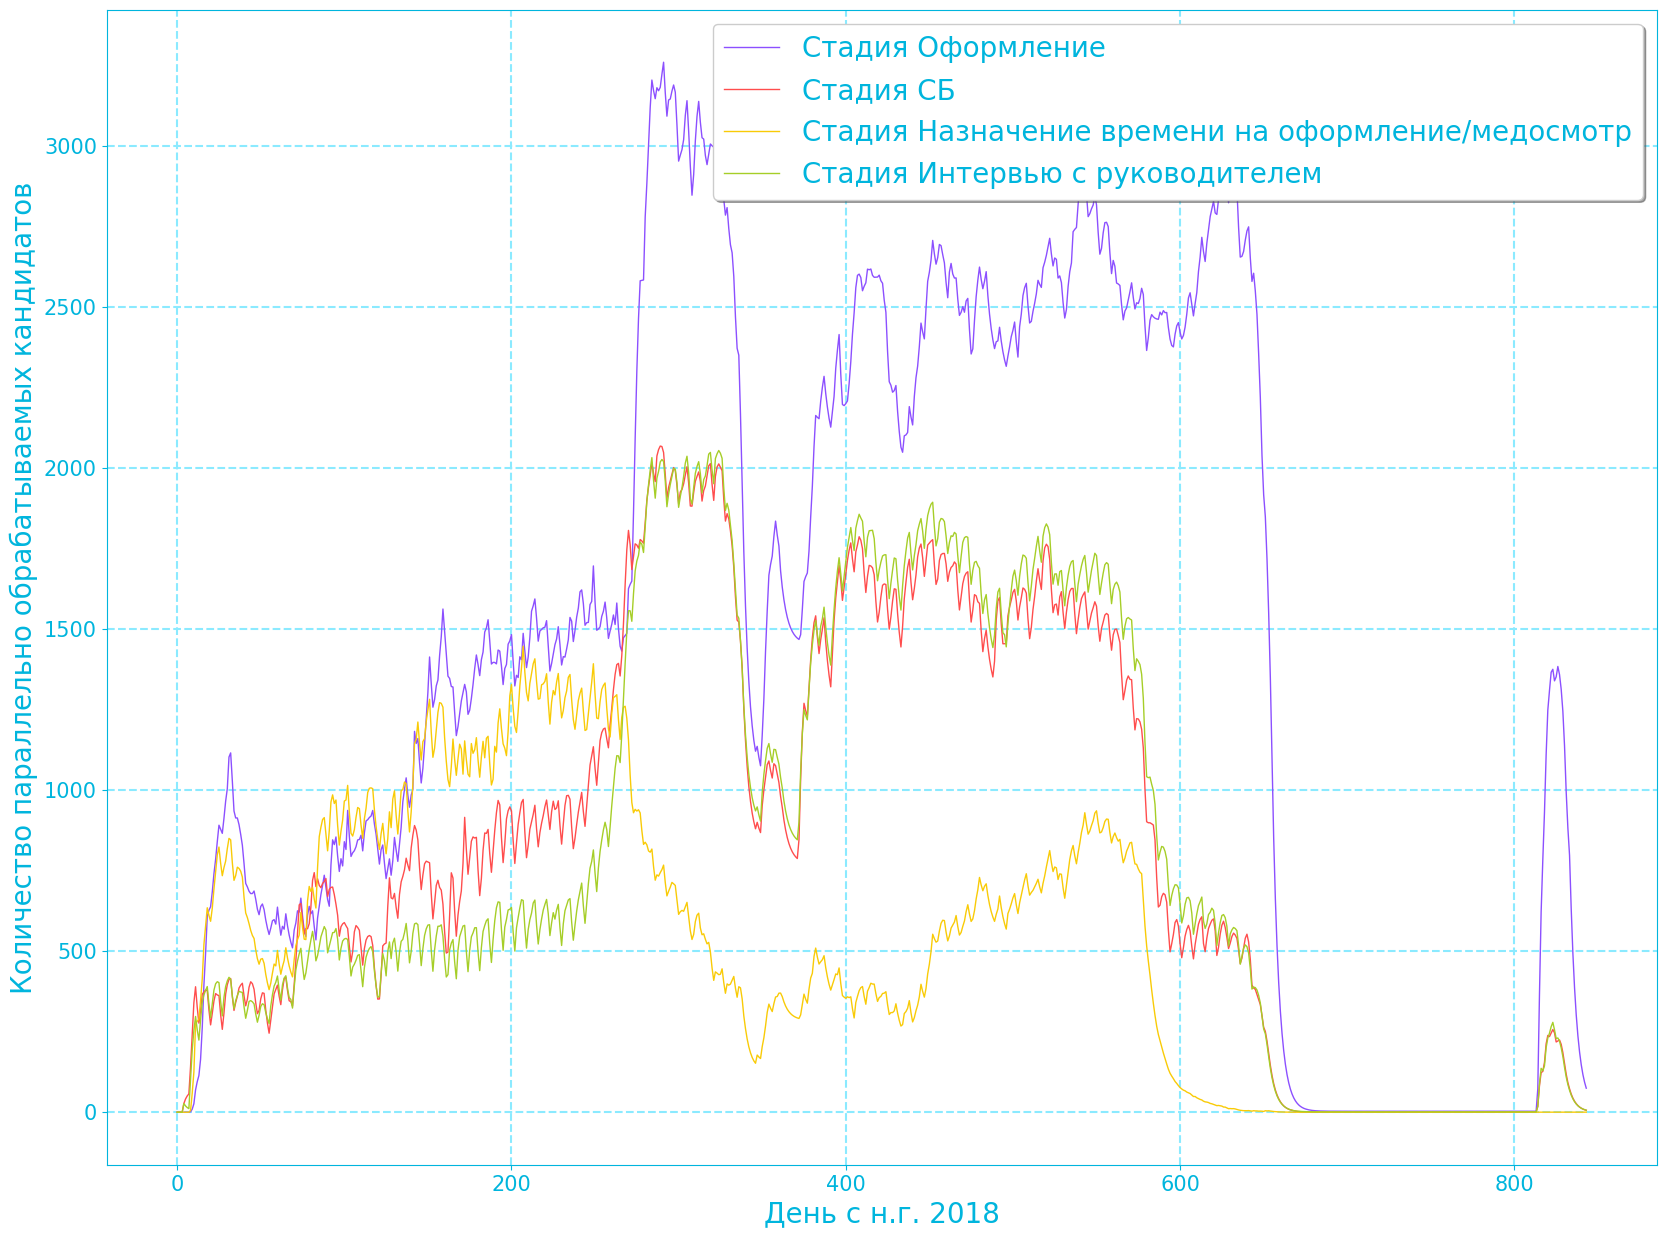

In [68]:
# График по среднему Загруженность сотрудников, участвующих в процессе найма за период 2018 н.г. - 2020 н.г. (по дням)
mask = np.isin(df_long_stages.columns, ['days'], invert = True)
df_long_stages_col = df_long_stages.columns[mask]
df_long_stages[df_long_stages_col] = df_long_stages[df_long_stages_col].ewm(com=3.5).mean()

i = 1
plt.subplots(figsize=(20,15))
for stage in long_stages:
    new_col_name = stage+ ' аппликатнов'
    df_long_stages =  df_long_stages.rename(columns={"applicants": new_col_name})
    plt.plot(df_long_stages['days'], df_long_stages[new_col_name], label="Стадия " + stage, linewidth=1.0, color = colors[i])

    i += 1

plt.xlabel('День с н.г. 2018',
              fontsize = 20)
plt.ylabel('Количество параллельно обрабатываемых кандидатов',
              fontsize = 20)
plt.legend(loc='best',fancybox=True, shadow=True,
              fontsize = 20)
plt.grid(True)
plt.grid(linewidth = 1.5, ls ='--', color = grid_color)
plt.savefig('weeks_zagruz.png')

In [69]:
# Длина ТТН по стадиям
df_long_stages.sort_values(by =['days'])

,days,Оформление аппликатнов,СБ аппликатнов,Назначение времени на оформление/медосмотр аппликатнов,Интервью с руководителем аппликатнов
0,0,0.000000,0.000000,0.000000e+00,0.000000
1,1,0.000000,0.000000,0.000000e+00,0.000000
2,2,0.000000,0.000000,0.000000e+00,0.000000
3,3,0.000000,0.000000,0.000000e+00,0.000000
4,4,0.000000,27.025567,0.000000e+00,27.025567
...,...,...,...,...,...
839,839,186.563835,16.060368,2.371183e-20,15.842336
840,840,147.327427,12.491397,1.844254e-20,12.544039
841,841,116.810221,9.715531,1.434419e-20,9.978697
842,842,93.074617,7.556524,1.115660e-20,7.983431


# Регрессия и XGboost

In [70]:
def addTimeToDF(df, column_name, result_name, new_res_name, temp):
    temp = df[df[column_name]==result_name]
    temp = temp.dropna(subset=['action_time']).groupby(['id_applicant'])['action_time'].sum().reset_index()
    temp = temp.rename(columns={"action_time": new_res_name})
    df = pd.merge(df, temp, how = 'left', on="id_applicant")
    df.fillna(value = {new_res_name:0}, inplace = True)
    return df
def dfMeanTime(df, column_name, result, result_new_name):
    df_mean = df[df[column_name]==result].groupby(['id_applicant'])['action_time'].mean().reset_index()
    df_mean = df_mean.rename(columns={"action_time": result_new_name})
    return df_mean
def dfRepitable(df, column_name, result_name, new_result_name):
    temp_df = df_norm[df_norm[column_name]==result_name].groupby(['id_applicant', 'activity_name', 'stage_name'])['action_date'].count().reset_index()
    temp_df = temp_df.rename(columns={"action_date": "amount"})
    temp_df = temp_df[temp_df['amount']>1]
    df = pd.merge(df, temp_df.groupby(['id_applicant'])['amount'].sum(), how = 'left', on="id_applicant")
    df = df.rename(columns={"amount": "amount_over_2calls"})
    df = pd.merge(df, temp_df.groupby(['id_applicant'])['amount'].count(), how = 'left', on="id_applicant")
    df = df.rename(columns={"amount": "count_over_2calls"})
    df['mean_over_2calls'] = df['amount_over_2calls'] / df['count_over_2calls'] - 1
    df[df['mean_over_2calls'] < 0] = 0
    df = df.drop(['amount_over_2calls', 'count_over_2calls'] , axis=1)
    df = df.rename(columns={"mean_over_2calls": new_result_name})
    return df

In [71]:
fits_min =  df_norm[df_norm['result_name'] == 'Принят'].groupby(['id_applicant'])['action_date'].min().reset_index()

In [72]:
def dfRepitableAll(df, column_name, result_name, new_result_name):
    temp_df = df_norm[df_norm[column_name]==result_name].groupby(['id_applicant', 'activity_name', 'stage_name'])['action_date'].count().reset_index()
    temp_df = temp_df.rename(columns={"action_date": "amount"})

    df = pd.merge(df, temp_df.groupby(['id_applicant'])['amount'].sum(), how = 'left', on="id_applicant")
    df = df.rename(columns={"amount": "amount_over_2calls"})
    df = pd.merge(df, temp_df.groupby(['id_applicant'])['amount'].count(), how = 'left', on="id_applicant")
    df = df.rename(columns={"amount": "count_over_2calls"})
    df['mean_over_2calls'] = df['amount_over_2calls'] / df['count_over_2calls'] - 1
    df[df['mean_over_2calls'] < 0] = 0
    df = df.drop(['amount_over_2calls', 'count_over_2calls'] , axis=1)
    df = df.rename(columns={"mean_over_2calls": new_result_name})
    return df

In [73]:
df_reg_all = df_tth_norm.reset_index(drop=True)
df_reg_all = dfRepitableAll(df_reg_all,'stage_name','Оформление', 'Оформление недозвоны' )
df_reg_all['Оформление недозвоны'].to_excel('nedozv.xlsx')

In [74]:
def cutData(df_reg, yColumn, xColumns_del = []):
    
    xColumn = df_reg.columns
    yColumn = yColumn
    xColumns_del.append(yColumn)
    mask = np.isin(xColumn, xColumns_del, invert = True)
    xColumn = xColumn[mask]
    
    return df_reg[xColumn], xColumn

In [75]:
def lm(df_reg, yColumn, xColumns_del = [], scaler = preprocessing.StandardScaler()):
    
    xColumn = df_reg.columns
    yColumn = yColumn
    xColumns_del.append(yColumn)
    mask = np.isin(xColumn, xColumns_del, invert = True)
    xColumn = xColumn[mask]
            
    lr = LinearRegression()

    X_c = sm.add_constant(df_reg[xColumn])

    model = sm.OLS(df_reg[yColumn],X_c)
    fitted_model = model.fit()
    
    return fitted_model, xColumn, fitted_model.predict(X_c)

def vizScatTTHPred(df, predicted, xColumns, yColumn):
    column_names = ['Кол-во недозвонов(оформление)', 'СБ', 'Интервью' ]
    xy = math.ceil(math.sqrt(len(xColumns)))
    if xy <2:
        xy = 2
    fig, axs = plt.subplots(xy, xy, figsize=(13,13))
    i = 0
    for column in xColumns:
        x, y =divmod(i, xy)    
        axs[x,y].set_ylabel("TTH, дни")
        axs[x,y].set_xlabel(column_names[i])
        axs[x,y].scatter(df[column], df[yColumn],s=3, label="Оригинальные", color = '#a6ce28')
        axs[x,y].scatter(df[column], predicted,s=3, label="Предсказанные", color = '#8c50ff')
        i += 1
        axs[x,y].grid(True)
        axs[x,y].grid(linewidth = 0.5, ls ='--', color = grid_color)
        axs[x,y].legend(loc='best',fancybox=True, shadow=True,
              fontsize = 10)
    plt.savefig('res_pred.png')
    
def vizResTTHPred(df, predicted, xColumns, yColumn):
    column_names = ['Кол-во недозвонов(оформление)', 'СБ', 'Интервью' ]
    xy = math.ceil(math.sqrt(len(xColumns)))
    if xy <2:
        xy = 2
    fig, axs = plt.subplots(xy, xy, figsize=(13,13))
    i = 0
    df.loc[:, 'res'] = df[yColumn] - predicted
    for column in xColumns:
        x, y =divmod(i, xy)    
        axs[x,y].set_ylabel("TTH, дни")
        axs[x,y].set_xlabel(column_names[i])
        axs[x,y].scatter(df[column],df['res'],s=3, color = '#a6ce28')
        i += 1
        axs[x,y].grid(True)
        axs[x,y].grid(linewidth = 0.5, ls ='--', color = grid_color)
    plt.savefig('res_ost.png')
    df.drop(['res'] , axis=1)

In [76]:
def cutData(df_reg, yColumn, xColumns_del = []):
    
    xColumn = df_reg.columns
    yColumn = yColumn
    xColumns_del.append(yColumn)
    mask = np.isin(xColumn, xColumns_del, invert = True)
    xColumn = xColumn[mask]
    
    return df_reg[xColumn], xColumn

In [84]:
# Визуализация

df_reg.to_excel('Final_reg_month.xlsx')

# Количество аппликантов в среднем за неделю
stages_place = df_norm.groupby(['stage_name'])['place'].mean().sort_values().reset_index()
stages_name = stages_place['stage_name'].values

stages_place =pd.merge(stages_place, df_norm.groupby(['stage_name'])['action_time'].describe().reset_index(), how = 'left', on="stage_name") 
stages_place =pd.merge(stages_place, df_norm.groupby(['stage_name'])['action_time'].sum().reset_index(), how = 'left', on="stage_name") 
stages_place = stages_place.rename(columns = {'action_time':'sum'})
stages_place['% от общей'] = stages_place['sum'] / stages_place['sum'].sum()
stages_place

# df_reg.sum()
oform_time = dfMeanTime(df_norm, 'stage_name','Оформление', "Оформление (время)" )

df_reg

,id_applicant,id_partner,department_id,TTH,month_start
0,2196746,2393754,6715,27.685659,2
1,2196747,2314693,12252,6.133310,1
2,2196748,2346300,5760,28.251127,2
3,2196752,2393757,32391,17.202996,1
4,2196753,2393758,32156,10.153854,1
...,...,...,...,...,...
164266,4874547,3857100,35046,2.984132,4
164267,4874561,3843493,24135,2.981270,4
164268,4874899,3847746,45624,2.944752,4
164269,4875075,3873082,9996,2.186676,4


In [85]:
# Был ли чел в резерве
temp_df = df[df['stage_name']=='Резерв'].id_partner.unique()
df_reg = df_tth_norm.reset_index(drop=True)

# Сезонность? (В какой месяц?) - 11 бинарных переменных
df_reg = pd.merge(df_reg, fits_min[['id_applicant','action_date']], how = 'left', on="id_applicant")
df_reg['month_start'] = df_reg['action_date'].dt.month
df_reg = df_reg.drop(['action_date'] , axis=1)


monthes = []
for column in xColumn:
    if 'month' in column:
        monthes.append(column)

# Сколько раз повторяются этапы на стадии (activity + stage name)
df_reg = dfRepitable(df_reg,'stage_name','Оформление', 'Оформление недозвоны' )

# Количество аппликантов в среднем за неделю
df_reg = pd.merge(df_reg, df_norm.groupby(['id_applicant'])[df_long_stages_col].mean().reset_index(), how = 'left', on="id_applicant")
df_reg = pd.merge(df_reg, dfMeanTime(df_norm, 'stage_name','СБ', "СБ (время)" ), how = 'left', on="id_applicant")
df_reg = pd.merge(df_reg, dfMeanTime(df_norm, 'stage_name','Интервью с руководителем', "Интервью с руководителем (время)" ), how = 'left', on="id_applicant")
df_reg = pd.merge(df_reg, dfMeanTime(df_norm, 'stage_name','Оформление', "Оформление (время)" ), how = 'left', on="id_applicant")

df_reg['СБ (время/среднее)'] = df_reg['СБ (время)'] / df_reg['СБ (время)'].mean()
df_reg['Интервью с руководителем (время/среднее)'] = df_reg['Интервью с руководителем (время)'] / df_reg['Интервью с руководителем (время)'].mean()
print( df_reg['Интервью с руководителем (время)'].describe())
print( df_reg['СБ (время)'].describe())

df_reg = df_reg.drop(['Интервью с руководителем (время)', 'СБ (время)', 'Оформление (время)'] , axis=1)
df_reg = df_reg.drop(['Интервью с руководителем аппликатнов', 'СБ аппликатнов', 'Назначение времени на оформление/медосмотр аппликатнов', 'Оформление аппликатнов'] , axis=1)
df_reg = df_reg.rename(columns={"Интервью с руководителем (время/среднее)": "Интервью (время/среднее)"})


# Время по стадиям
df_reg.replace([np.inf, -np.inf], np.nan, inplace=True)
print(df_reg.isna().sum())
df_reg = df_reg.fillna(0)
df_reg

count    161928.000000
mean          0.263012
std           1.472932
min           0.000000
25%           0.000009
50%           0.000011
75%           0.000015
max          82.179529
Name: Интервью с руководителем (время), dtype: float64
count    161997.000000
mean          1.116662
std           2.402785
min           0.000000
25%           0.305746
50%           0.534006
75%           1.000421
max          92.971844
Name: СБ (время), dtype: float64
id_applicant                    0
id_partner                      0
department_id                   0
TTH                             0
month_start                     0
Оформление недозвоны        54982
СБ (время/среднее)           2274
Интервью (время/среднее)     2343
dtype: int64


,id_applicant,id_partner,department_id,TTH,month_start,Оформление недозвоны,СБ (время/среднее),Интервью (время/среднее)
0,2196746,2393754,6715,27.685659,2,3.0,1.843986,0.000023
1,2196747,2314693,12252,6.133310,1,0.0,2.287242,0.000026
2,2196748,2346300,5760,28.251127,2,0.0,2.297314,0.000026
3,2196752,2393757,32391,17.202996,1,4.0,2.331441,0.000022
4,2196753,2393758,32156,10.153854,1,1.0,1.837830,0.000025
...,...,...,...,...,...,...,...,...
164266,4874547,3857100,35046,2.984132,4,0.0,0.000011,0.000053
164267,4874561,3843493,24135,2.981270,4,0.0,0.000010,0.000043
164268,4874899,3847746,45624,2.944752,4,0.0,0.869699,0.059207
164269,4875075,3873082,9996,2.186676,4,1.0,0.000050,0.000046


In [91]:
df_new, xColumn = cutData(df_reg,yColumn,['id_partner', 'department_id', 'id_applicant', 'TTH', 'year 2', 'month 12', 'yandex_source'])

model_xgb = xgboost.XGBRegressor().fit(df_new, df_reg['TTH'])
model_xgb.score(df_new, df_reg['TTH']) 

0.3923778511921646

In [92]:
y_pred = model_xgb.predict(df_new)
r_squared = r2_score(df_reg['TTH'], y_pred)
adjusted_r_squared = 1 - (1-r_squared)*(len(df_reg['TTH'])-1)/(len(df_reg['TTH'])-df_new.shape[1]-1)
print('R2 = '+str(r_squared))
print('R2 adj = '+str(adjusted_r_squared))

R2 = 0.3923778511921646
R2 adj = 0.39236305513823244


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


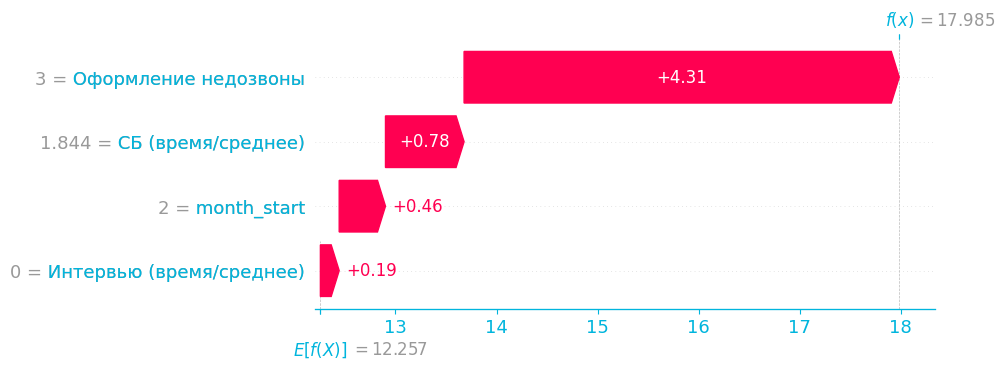

In [93]:
explainer = shap.Explainer(model_xgb)
shap_values = explainer(df_new)

# visualize the first prediction's explanation

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 15, 'text.color': colors[0],
                     'axes.labelcolor': colors[0], 'xtick.color': colors[0], 'ytick.color': colors[0],
                     'axes.edgecolor': colors[0], 'ytick.color': colors[0]})
shap.plots.waterfall(shap_values[0])

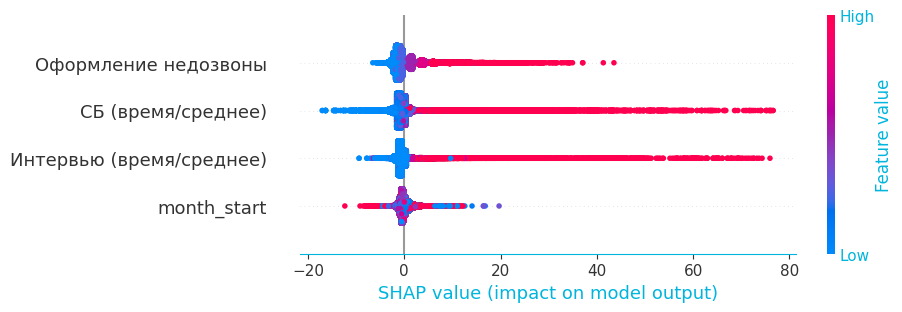

In [94]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 15, 'text.color': colors[0],
                     'axes.labelcolor': colors[0], 'xtick.color': colors[0], 'ytick.color': colors[0],
                     'axes.edgecolor': colors[0], 'ytick.color': colors[0]})

shap.plots.beeswarm(shap_values)

In [95]:
yColumn = "TTH"
fitted_model, xColumn, predicted = lm(df_reg,yColumn,['id_partner', 'department_id', 'id_applicant', 'TTH', 'year 2', 'month 12', 'yandex_source'], preprocessing.StandardScaler())
fitted_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
======================================================================
Model:               OLS              Adj. R-squared:     0.264       
Dependent Variable:  TTH              AIC:                1201090.0636
Date:                2022-06-08 12:44 BIC:                1201140.1099
No. Observations:    164271           Log-Likelihood:     -6.0054e+05 
Df Model:            4                F-statistic:        1.473e+04   
Df Residuals:        164266           Prob (F-statistic): 0.00        
R-squared:           0.264            Scale:              87.683      
----------------------------------------------------------------------
                         Coef.  Std.Err.    t     P>|t|  [0.025 0.975]
----------------------------------------------------------------------
const                    6.8787   0.0591 116.3272 0.0000 6.7628 6.9946
month_start              0.0549   0.0077   7.1032 0.0000 0.0398 0.0701
Оформление недозвоны     2.0830   0.0168 124.1032 0.0000 2.0501 2.1159
СБ (время/среднее)       1.9969   0.0109 182.5972 0.0000 1.9755 2.0183
Интервью (время/среднее) 0.5559   0.0042 133.7029 0.0000 0.5478 0.5641
----------------------------------------------------------------------
Omnibus:            104391.943      Durbin-Watson:         1.913      
Prob(Omnibus):      0.000           Jarque-Bera (JB):      1402877.827
Skew:               2.898           Prob(JB):              0.000      
Kurtosis:           16.091          Condition No.:         19         
======================================================================

"""